In [1]:
import sys
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/gaussfiltax')

import time

from jax import numpy as jnp
from jax import random as jr
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
# import tensorflow as tf
# tf.test.gpu_device_name()

import gaussfiltax.utils as utils
import gaussfiltax.inference as gf
from gaussfiltax.inference import ParamsUKF, _ukf_predict_nonadditive
from gaussfiltax.models import ParamsNLSSM, NonlinearSSM, ParamsBPF

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Models and simulations

In [2]:
# Parameters
state_dim = 4
state_noise_dim = 2
emission_dim = 2
emission_noise_dim = 2
seq_length = 30
mu0 = 1.0 * jnp.array([-0.05, 0.001, 0.7, -0.05])
q0 = jnp.zeros(state_noise_dim)
r0 = jnp.zeros(emission_noise_dim)
Sigma0 = 1.0 * jnp.array([[0.1, 0.0, 0.0, 0.0],[0.0, 0.005, 0.0, 0.0],[0.0, 0.0, 0.1, 0.0],[0.0, 0.0, 0.0, 0.01]])
Q = 1e-6 * jnp.eye(state_noise_dim)
R = 25*1e-6 * jnp.eye(emission_noise_dim)

dt = 0.5
FCV = jnp.array([[1, dt, 0, 0],[0, 1, 0, 0],[0, 0, 1, dt],[0, 0, 0, 1]])
acc = 0.5
Omega = lambda x, acc: 0.1 * acc / jnp.sqrt(x[1]**2 + x[3]**2)
FCT =  lambda x, a: jnp.array([[1, jnp.sin(dt * Omega(x, a)) / Omega(x, a), 0, -(1-jnp.cos(dt * Omega(x, a))) / Omega(x, a)],
                            [0, jnp.cos(dt * Omega(x, a)), 0, -jnp.sin(dt * Omega(x, a))],
                            [0, (1-jnp.cos(dt * Omega(x, a))) / Omega(x, a), 1, jnp.sin(dt * Omega(x, a)) / Omega(x, a)],
                            [0, jnp.sin(dt * Omega(x, a)), 0, jnp.cos(dt * Omega(x, a))]])

G = jnp.array([[0.5, 0],[1, 0],[0, 0.5],[0, 1]])
fBOT = lambda x, q, u: FCV @ x + G @ q
fManBOT = lambda x, q, u: (0.5*(u-1)*(u-2)*FCV - u*(u-2)*FCT(x, acc) + 0.5*u*(u-1) * FCT(x, -acc)) @ x + G @ q
gBOT = lambda x, r, u: jnp.arctan2(x[2], x[0]) + r
gBOT2 = lambda x ,r, u: jnp.array([jnp.arctan2(x[2], x[0]), jnp.sqrt(x[0]**2 + x[2]**2)]) + r
gBOTlp = lambda x, y, u: MVN(loc = gBOT2(x, r0, u), covariance_matrix = R).log_prob(y)
# inputs = jnp.zeros((seq_length, 1))
inputs = jnp.array([1]*int(seq_length/3) + [0]*int(seq_length/3) + [2]*int(seq_length/3)) # maneuver inputs

In [3]:
f = fManBOT
g = gBOT2
glp = gBOTlp

In [4]:
# initialization
model = NonlinearSSM(state_dim, state_noise_dim, emission_dim, emission_noise_dim)
params = ParamsNLSSM(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias= q0,
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias= r0,
    emission_noise_covariance=R,
)

## Experiments

sim 1/100
key0:  [3568232559  713140391]
key:  [3620866055 2761185182]
       Time taken for GSF:  1.1039910316467285
       Time taken for UGSF:  1.1540720462799072
       Time taken for AGSF:  5.398148059844971
       Time taken for UAGSF:  5.527158975601196
       Time taken for BPF:  0.7872319221496582
              GSF RMSE: 0.045679428
              UGSF RMSE: 0.05236849
              AGSF RMSE: 0.4617481
              UAGSF RMSE: 0.79780465
              BPF RMSE: 2.8710027


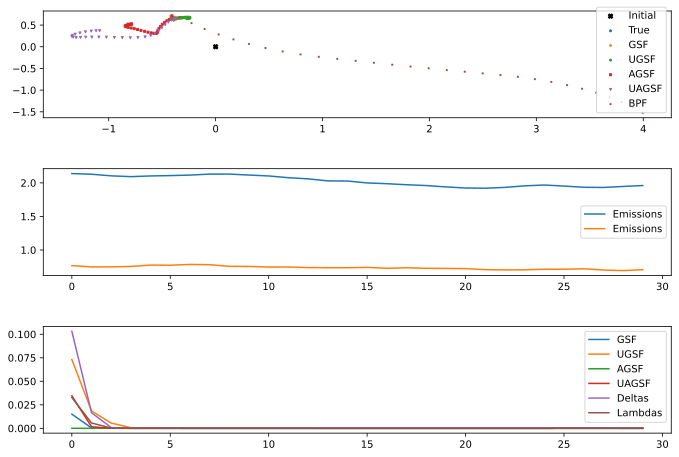

sim 2/100
key0:  [1465327881 3584627995]
key:  [1697684642 2171187924]
       Time taken for GSF:  0.9201488494873047
       Time taken for UGSF:  0.9352700710296631
       Time taken for AGSF:  5.251938819885254
       Time taken for UAGSF:  5.488790988922119
       Time taken for BPF:  0.5312619209289551
              GSF RMSE: 0.039077807
              UGSF RMSE: 0.050189734
              AGSF RMSE: 0.4728774
              UAGSF RMSE: 0.79137486
              BPF RMSE: 0.88288516


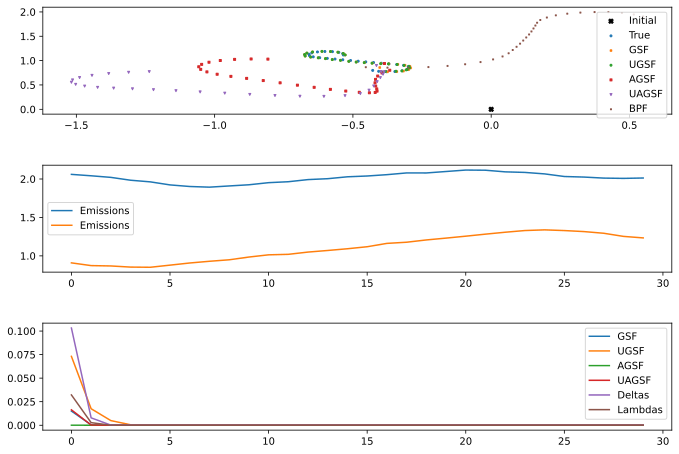

sim 3/100
key0:  [2140591709 3509555027]
key:  [704465164 725215309]
       Time taken for GSF:  0.8409290313720703
       Time taken for UGSF:  1.0705389976501465
       Time taken for AGSF:  5.036432981491089
       Time taken for UAGSF:  5.425329208374023
       Time taken for BPF:  0.530081033706665
              GSF RMSE: 0.023573162
              UGSF RMSE: 0.027682602
              AGSF RMSE: 1.7592326
              UAGSF RMSE: 1.4400214
              BPF RMSE: 0.88137317


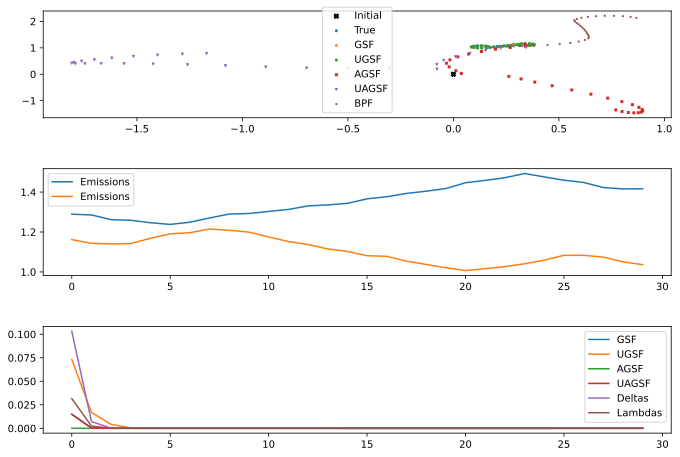

sim 4/100
key0:  [1303716432 1855432450]
key:  [2242020428 1473874242]
       Time taken for GSF:  1.0243730545043945
       Time taken for UGSF:  0.9463198184967041
       Time taken for AGSF:  5.364279747009277
       Time taken for UAGSF:  5.435673236846924
       Time taken for BPF:  0.5342731475830078
              GSF RMSE: 0.030425588
              UGSF RMSE: 0.040993743
              AGSF RMSE: 0.17771514
              UAGSF RMSE: 0.119640194
              BPF RMSE: 1.5033233


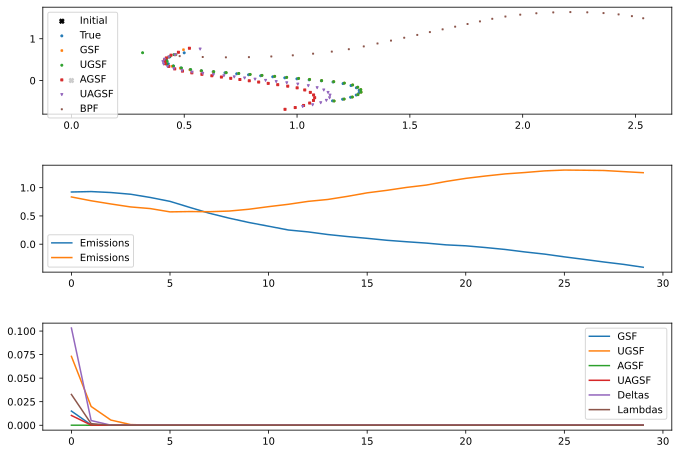

sim 5/100
key0:  [3538396939 1919323064]
key:  [ 339212260 4043306578]
       Time taken for GSF:  0.8894720077514648
       Time taken for UGSF:  1.1342589855194092
       Time taken for AGSF:  5.151569128036499
       Time taken for UAGSF:  5.579797983169556
       Time taken for BPF:  0.5333359241485596
              GSF RMSE: 0.024634201
              UGSF RMSE: 0.03182431
              AGSF RMSE: 0.18900026
              UAGSF RMSE: 0.25261614
              BPF RMSE: 0.4513469


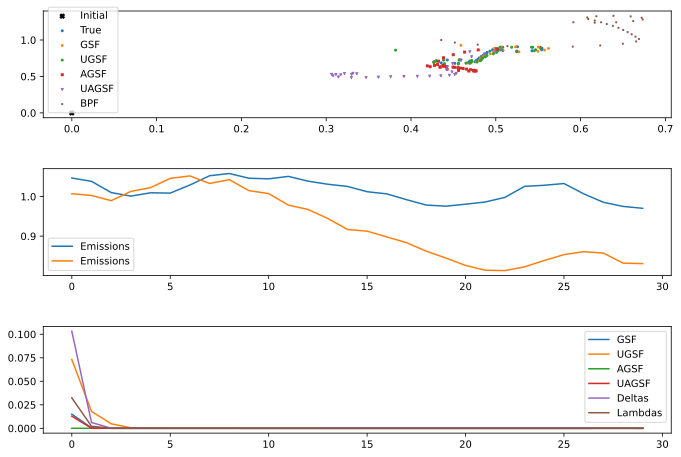

sim 6/100
key0:  [1897248577 2211687077]
key:  [2260205803 3719488220]
       Time taken for GSF:  0.8450210094451904
       Time taken for UGSF:  1.1755609512329102
       Time taken for AGSF:  5.0856709480285645
       Time taken for UAGSF:  5.150993347167969
       Time taken for BPF:  0.5087950229644775
              GSF RMSE: 0.030386774
              UGSF RMSE: 0.04574043
              AGSF RMSE: 0.21542396
              UAGSF RMSE: 0.21554591
              BPF RMSE: 1.6686335


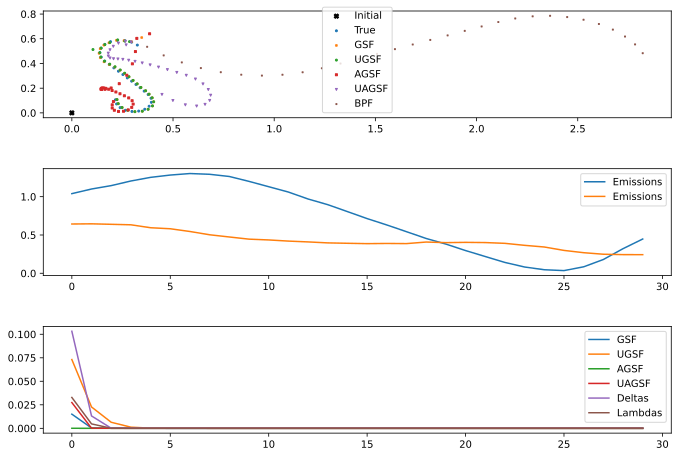

sim 7/100
key0:  [3004561477  573555509]
key:  [1598224098 3185611331]
       Time taken for GSF:  0.7973208427429199
       Time taken for UGSF:  0.8910040855407715
       Time taken for AGSF:  4.998613119125366
       Time taken for UAGSF:  5.137212038040161
       Time taken for BPF:  0.5044012069702148
              GSF RMSE: 0.027512748
              UGSF RMSE: 0.047571685
              AGSF RMSE: 0.13452718
              UAGSF RMSE: 0.32422155
              BPF RMSE: 1.4068335


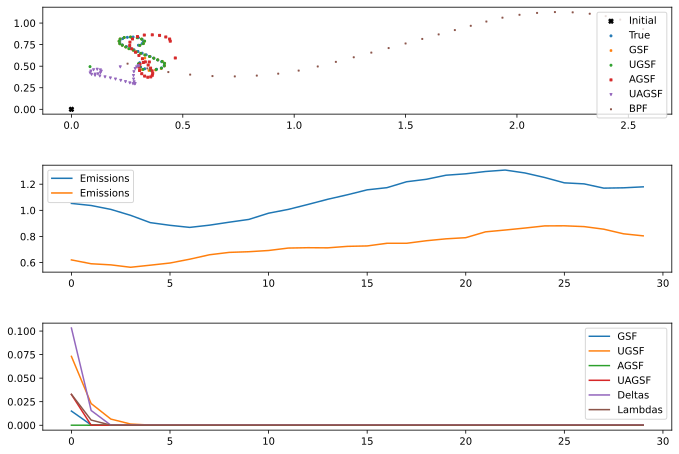

sim 8/100
key0:  [1641975508 2801076567]
key:  [ 858213663 2181881252]
       Time taken for GSF:  1.0780699253082275
       Time taken for UGSF:  0.9071998596191406
       Time taken for AGSF:  5.014830112457275
       Time taken for UAGSF:  4.896965980529785
       Time taken for BPF:  0.8071310520172119
              GSF RMSE: 0.03729066
              UGSF RMSE: 0.043429278
              AGSF RMSE: 0.23062511
              UAGSF RMSE: 0.24730177
              BPF RMSE: 1.7985115


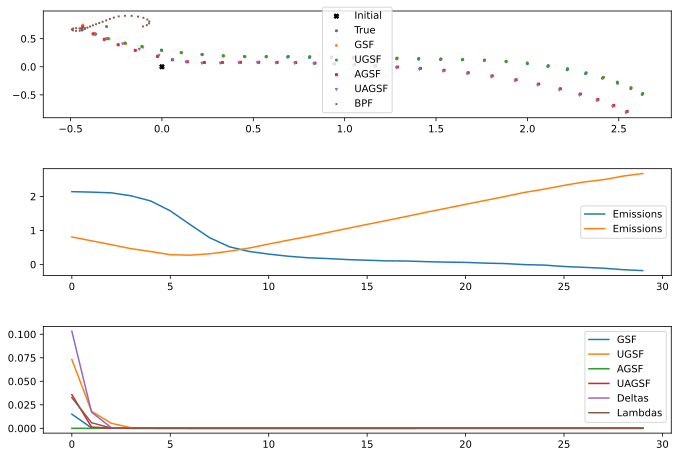

sim 9/100
key0:  [2964592761 3963767653]
key:  [1703955756 4117464756]
       Time taken for GSF:  0.8577768802642822
       Time taken for UGSF:  0.9332621097564697
       Time taken for AGSF:  5.10345983505249
       Time taken for UAGSF:  5.263857364654541
       Time taken for BPF:  0.49796628952026367
              GSF RMSE: 0.08555962
              UGSF RMSE: 0.07870419
              AGSF RMSE: 0.4011335
              UAGSF RMSE: 0.44741642
              BPF RMSE: 1.5084388


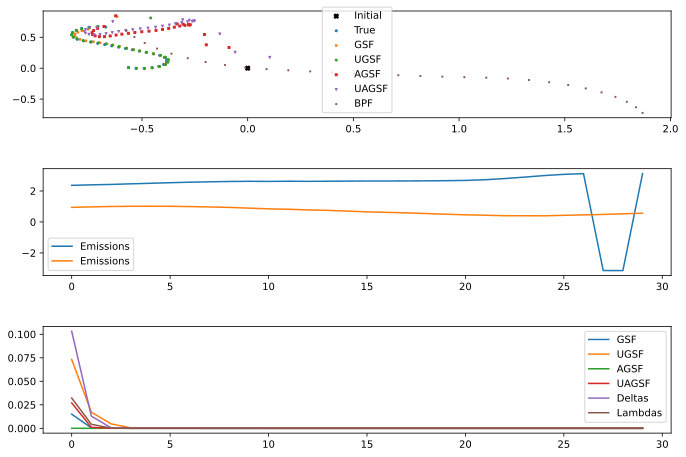

sim 10/100
key0:  [ 750034854 1626364709]
key:  [2376732689 1821473027]
       Time taken for GSF:  0.7930271625518799
       Time taken for UGSF:  0.8870232105255127
       Time taken for AGSF:  5.090754747390747
       Time taken for UAGSF:  4.900973081588745
       Time taken for BPF:  0.5036849975585938
              GSF RMSE: nan
              UGSF RMSE: 0.105651565
              AGSF RMSE: 0.32519382
              UAGSF RMSE: 1.0748303
              BPF RMSE: 0.58856905


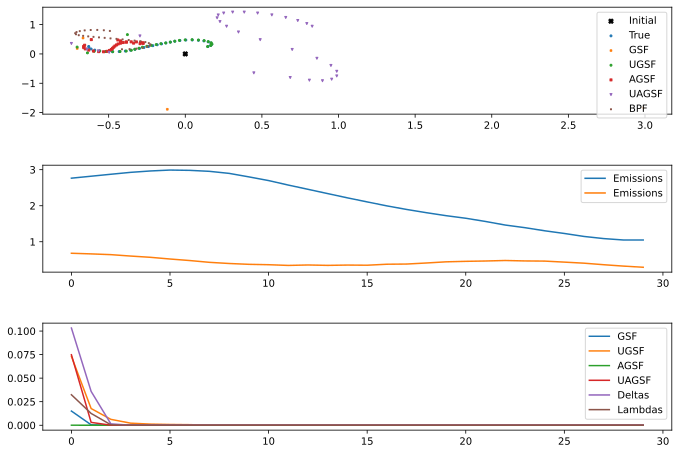

sim 11/100
key0:  [2473269265 1930548377]
key:  [1355056684 1763165466]
       Time taken for GSF:  1.1646921634674072
       Time taken for UGSF:  0.9006659984588623
       Time taken for AGSF:  4.756695032119751
       Time taken for UAGSF:  5.300673961639404
       Time taken for BPF:  0.5052759647369385
              GSF RMSE: nan
              UGSF RMSE: 0.07143801
              AGSF RMSE: 0.4085303
              UAGSF RMSE: 0.6613097
              BPF RMSE: 1.2885337


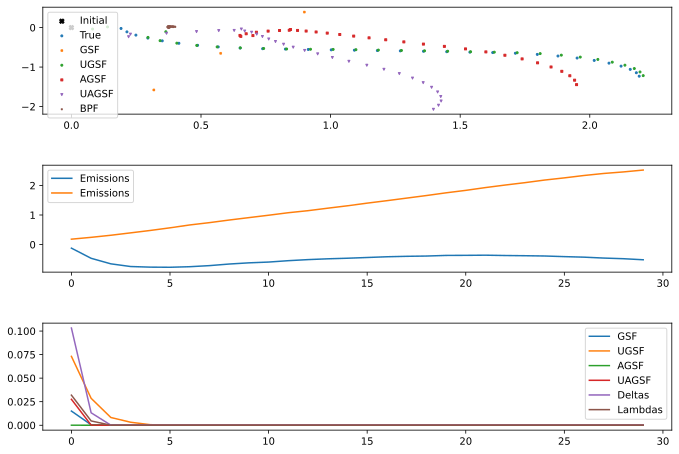

sim 12/100
key0:  [2242128751 2689217281]
key:  [3601313016  705004009]
       Time taken for GSF:  0.8100130558013916
       Time taken for UGSF:  0.897611141204834
       Time taken for AGSF:  5.101188898086548
       Time taken for UAGSF:  5.395040035247803
       Time taken for BPF:  0.5205349922180176
              GSF RMSE: 0.043115575
              UGSF RMSE: 0.030498024
              AGSF RMSE: 0.21421151
              UAGSF RMSE: 1.2359662
              BPF RMSE: 1.6748438


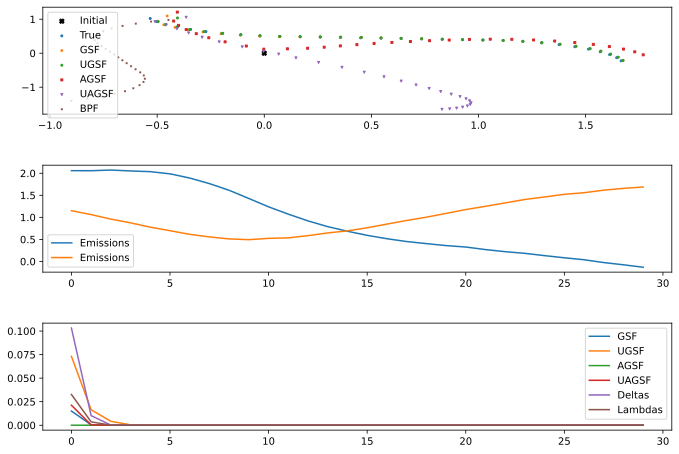

sim 13/100
key0:  [581586835 330633787]
key:  [3784394595 4044246026]
       Time taken for GSF:  0.79518723487854
       Time taken for UGSF:  0.8902838230133057
       Time taken for AGSF:  5.354649782180786
       Time taken for UAGSF:  4.866101026535034
       Time taken for BPF:  0.5049548149108887
              GSF RMSE: 0.059727065
              UGSF RMSE: 0.04566123
              AGSF RMSE: 0.9062639
              UAGSF RMSE: 1.3367705
              BPF RMSE: 1.3396807


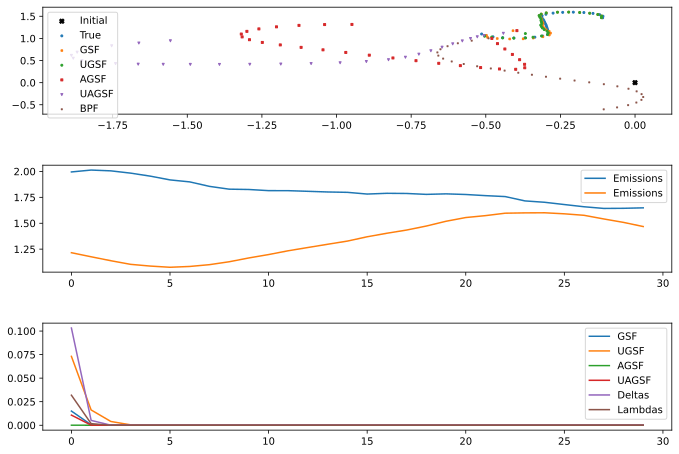

sim 14/100
key0:  [488089718 318464779]
key:  [ 979764689 1026999993]
       Time taken for GSF:  0.793590784072876
       Time taken for UGSF:  0.9684090614318848
       Time taken for AGSF:  5.677335023880005
       Time taken for UAGSF:  5.300678968429565
       Time taken for BPF:  0.5404949188232422
              GSF RMSE: 0.031912662
              UGSF RMSE: 0.036721364
              AGSF RMSE: 0.4272398
              UAGSF RMSE: 0.33569852
              BPF RMSE: 0.04893617


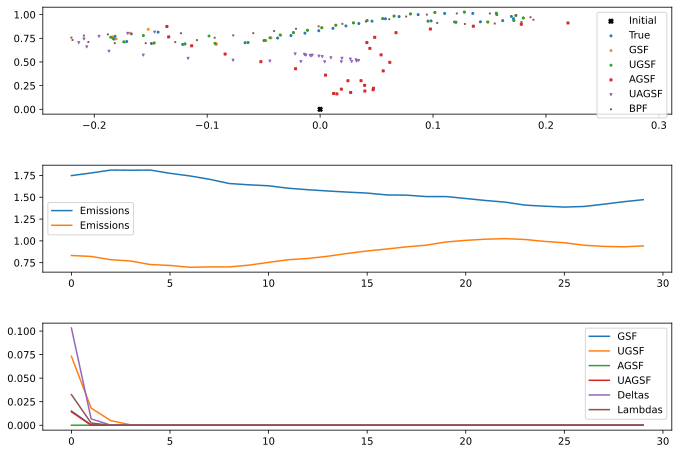

sim 15/100
key0:  [1491761296  588544249]
key:  [1968947799 1282838610]
       Time taken for GSF:  0.8690929412841797
       Time taken for UGSF:  0.9644231796264648
       Time taken for AGSF:  5.102684020996094
       Time taken for UAGSF:  5.706674814224243
       Time taken for BPF:  0.5072870254516602
              GSF RMSE: 0.03391675
              UGSF RMSE: 0.058067653
              AGSF RMSE: 1.2436874
              UAGSF RMSE: 1.8008473
              BPF RMSE: 1.3937289


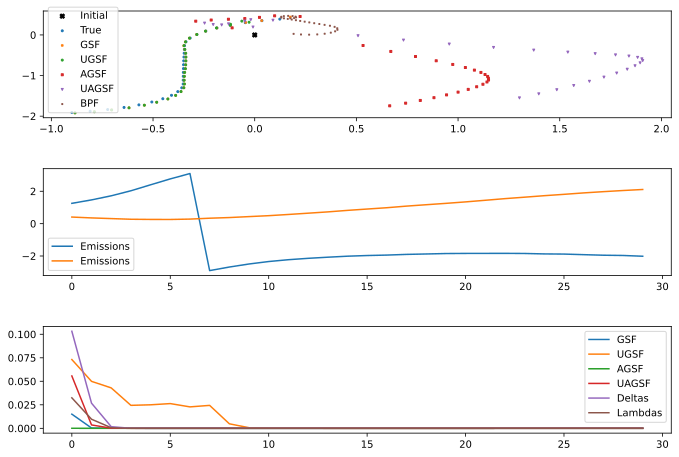

sim 16/100
key0:  [2142401925  580756533]
key:  [2808712755 3382142284]
       Time taken for GSF:  0.8059358596801758
       Time taken for UGSF:  0.8864071369171143
       Time taken for AGSF:  5.288864850997925
       Time taken for UAGSF:  4.858651876449585
       Time taken for BPF:  0.5014986991882324
              GSF RMSE: 0.04439988
              UGSF RMSE: 0.060071886
              AGSF RMSE: 0.30608708
              UAGSF RMSE: 1.7748029
              BPF RMSE: 1.2755517


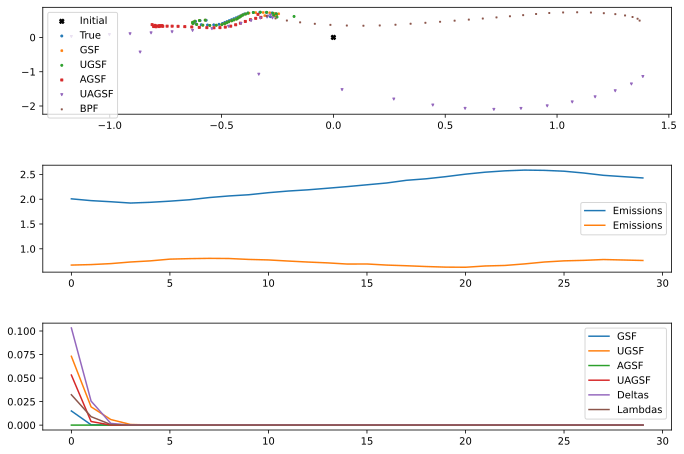

sim 17/100
key0:  [1214963262 2397950654]
key:  [2026553328  514088349]
       Time taken for GSF:  0.7941398620605469
       Time taken for UGSF:  0.8926770687103271
       Time taken for AGSF:  5.287590980529785
       Time taken for UAGSF:  4.874380111694336
       Time taken for BPF:  0.5096931457519531
              GSF RMSE: 0.04681396
              UGSF RMSE: 0.05499771
              AGSF RMSE: 0.4789404
              UAGSF RMSE: 0.62587816
              BPF RMSE: 0.6300373


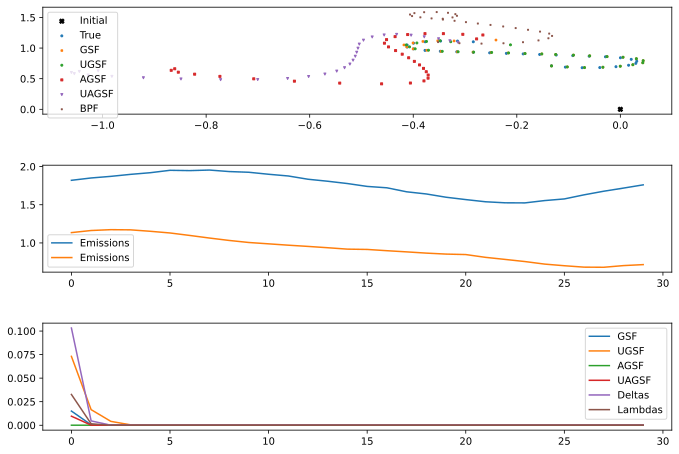

sim 18/100
key0:  [ 218736863 3855308191]
key:  [4161984306 3196801348]
       Time taken for GSF:  0.798192024230957
       Time taken for UGSF:  0.9132719039916992
       Time taken for AGSF:  5.287784814834595
       Time taken for UAGSF:  4.940372943878174
       Time taken for BPF:  0.5077269077301025
              GSF RMSE: 0.045667592
              UGSF RMSE: 0.047320053
              AGSF RMSE: 0.3529774
              UAGSF RMSE: 0.36405218
              BPF RMSE: 1.1815014


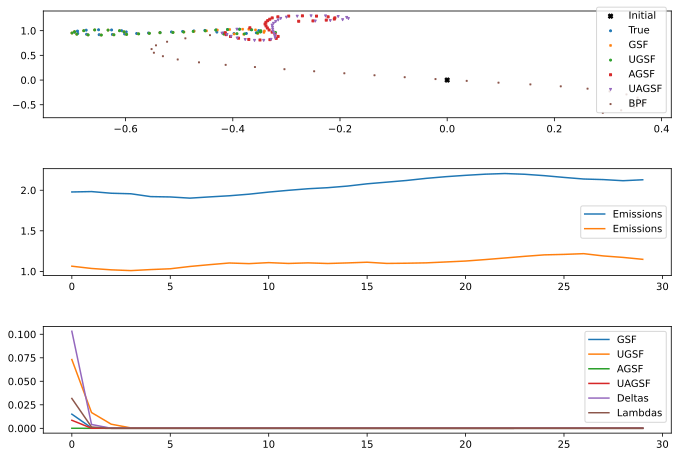

sim 19/100
key0:  [1151028487 2939992156]
key:  [1376876312 2772186225]
       Time taken for GSF:  0.8855628967285156
       Time taken for UGSF:  1.5993428230285645
       Time taken for AGSF:  4.684340000152588
       Time taken for UAGSF:  4.889616966247559
       Time taken for BPF:  0.5029098987579346
              GSF RMSE: 0.018994356
              UGSF RMSE: 0.025766255
              AGSF RMSE: 0.21139398
              UAGSF RMSE: 0.23482151
              BPF RMSE: 1.0223622


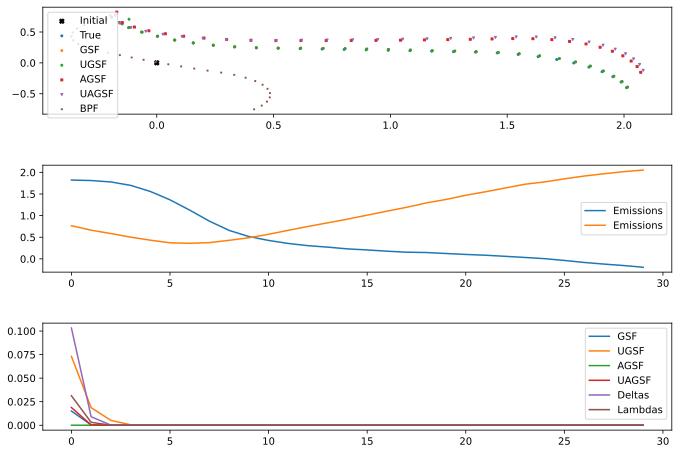

sim 20/100
key0:  [1209653932 4060347193]
key:  [2941757454  870593673]
       Time taken for GSF:  1.447180986404419
       Time taken for UGSF:  0.890880823135376
       Time taken for AGSF:  4.756900072097778
       Time taken for UAGSF:  4.815232038497925
       Time taken for BPF:  0.5068368911743164
              GSF RMSE: 0.033982962
              UGSF RMSE: 0.038731683
              AGSF RMSE: 0.2035284
              UAGSF RMSE: 0.18546832
              BPF RMSE: 1.0150857


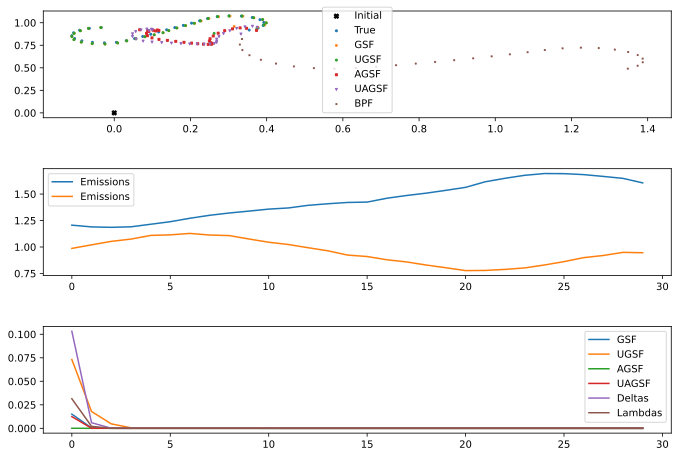

sim 21/100
key0:  [1294091905 2996091761]
key:  [2548412307  391727372]
       Time taken for GSF:  0.8051588535308838
       Time taken for UGSF:  1.6026301383972168
       Time taken for AGSF:  4.735074996948242
       Time taken for UAGSF:  4.96235990524292
       Time taken for BPF:  0.5149271488189697
              GSF RMSE: 0.028921457
              UGSF RMSE: 0.041520137
              AGSF RMSE: 0.34291932
              UAGSF RMSE: 0.20663755
              BPF RMSE: 0.8940304


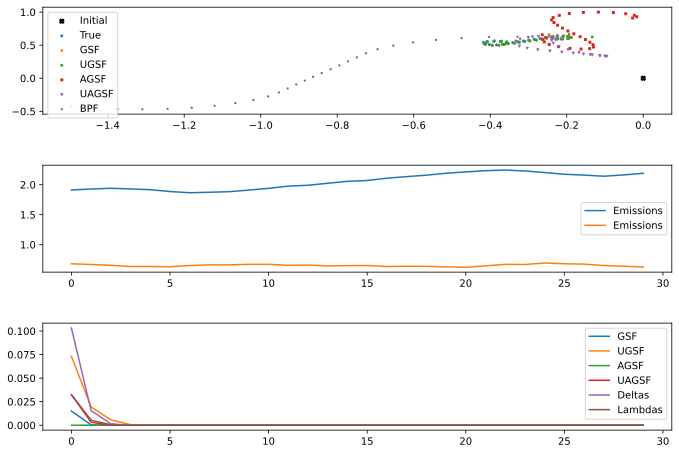

sim 22/100
key0:  [2157786727 3727309458]
key:  [3813321172 4101316537]
       Time taken for GSF:  0.804739236831665
       Time taken for UGSF:  1.6222810745239258
       Time taken for AGSF:  4.679808855056763
       Time taken for UAGSF:  4.958693027496338
       Time taken for BPF:  0.5089080333709717
              GSF RMSE: nan
              UGSF RMSE: 0.11699731
              AGSF RMSE: 1.1183732
              UAGSF RMSE: 1.5516096
              BPF RMSE: 1.0229961


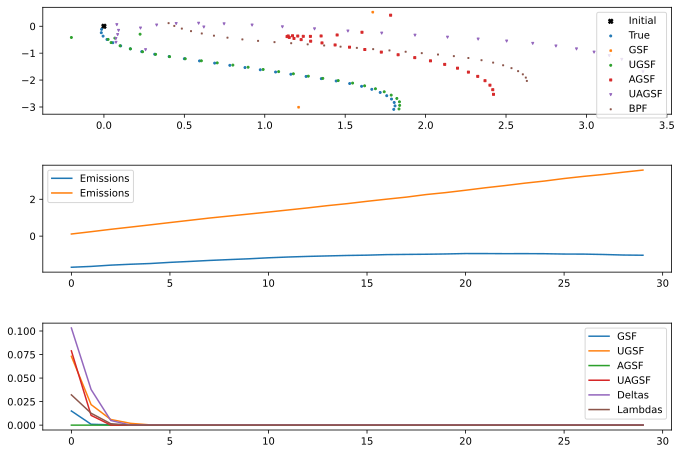

sim 23/100
key0:  [ 551681748 3783370645]
key:  [3170693929  505432508]
       Time taken for GSF:  0.7938201427459717
       Time taken for UGSF:  0.8961801528930664
       Time taken for AGSF:  5.442434072494507
       Time taken for UAGSF:  4.860467910766602
       Time taken for BPF:  0.5189759731292725
              GSF RMSE: 0.05562693
              UGSF RMSE: 0.064927995
              AGSF RMSE: 0.37179503
              UAGSF RMSE: 0.36776504
              BPF RMSE: 0.26673204


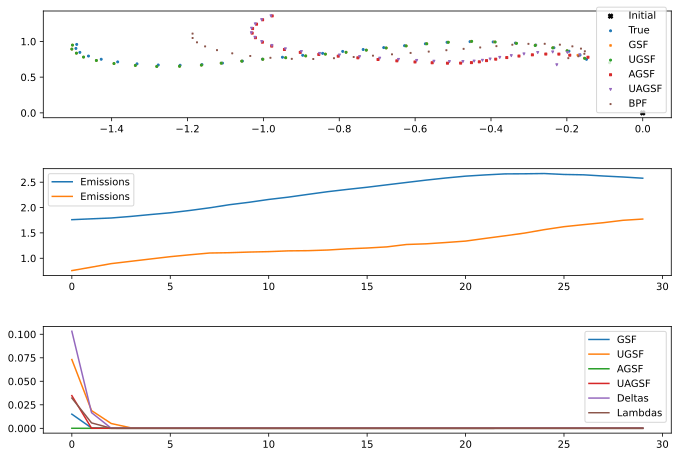

sim 24/100
key0:  [3225174916 3223194634]
key:  [1519423743 2956433696]
       Time taken for GSF:  0.8063511848449707
       Time taken for UGSF:  0.9593319892883301
       Time taken for AGSF:  5.571885824203491
       Time taken for UAGSF:  4.920691013336182
       Time taken for BPF:  0.5274839401245117
              GSF RMSE: 0.02572057
              UGSF RMSE: 0.023058949
              AGSF RMSE: 0.34677923
              UAGSF RMSE: 0.18262847
              BPF RMSE: 0.5856244


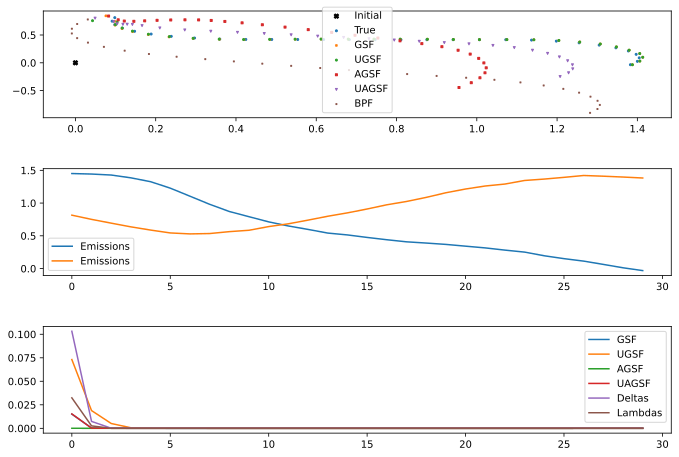

sim 25/100
key0:  [1210625804 1346048384]
key:  [ 593864388 3739305433]
       Time taken for GSF:  0.8638851642608643
       Time taken for UGSF:  0.9592998027801514
       Time taken for AGSF:  5.553705930709839
       Time taken for UAGSF:  4.949021816253662
       Time taken for BPF:  0.5053319931030273
              GSF RMSE: 0.058022715
              UGSF RMSE: 0.032315716
              AGSF RMSE: 2.129911
              UAGSF RMSE: 1.204023
              BPF RMSE: 0.5934933


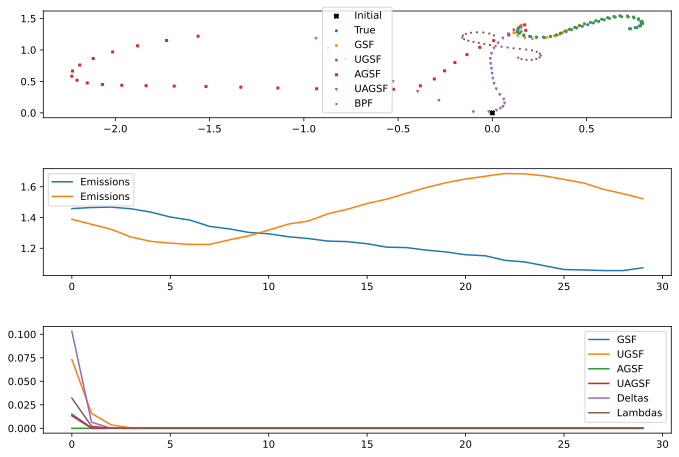

sim 26/100
key0:  [3352908700 3855442932]
key:  [2019875360  913777580]
       Time taken for GSF:  0.7934219837188721
       Time taken for UGSF:  0.8938770294189453
       Time taken for AGSF:  4.698454141616821
       Time taken for UAGSF:  5.7743120193481445
       Time taken for BPF:  0.5162560939788818
              GSF RMSE: 0.052353162
              UGSF RMSE: 0.04966411
              AGSF RMSE: 0.45685485
              UAGSF RMSE: 0.34759268
              BPF RMSE: 0.24232098


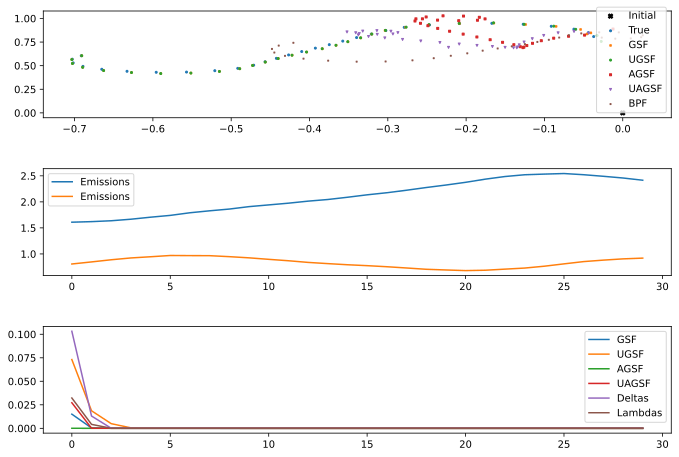

sim 27/100
key0:  [2424983569 3671623719]
key:  [ 886240072 1903776979]
       Time taken for GSF:  0.7938568592071533
       Time taken for UGSF:  0.9001169204711914
       Time taken for AGSF:  5.070413112640381
       Time taken for UAGSF:  5.401726961135864
       Time taken for BPF:  0.5392851829528809
              GSF RMSE: 0.023392992
              UGSF RMSE: 0.029266296
              AGSF RMSE: 0.26580375
              UAGSF RMSE: 0.40506724
              BPF RMSE: 0.7553302


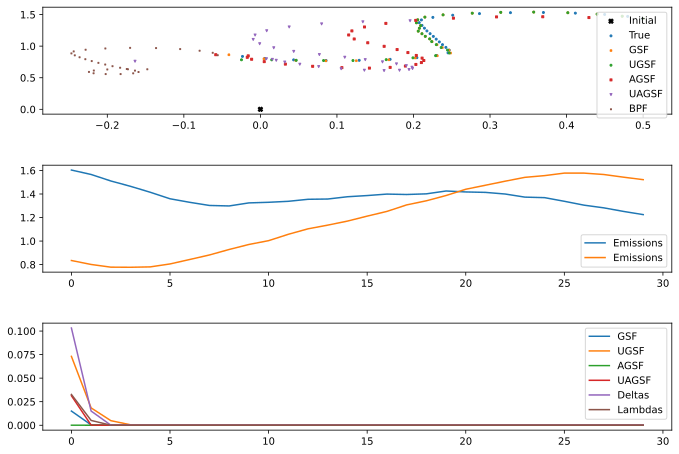

sim 28/100
key0:  [3682768791 4179160189]
key:  [3658883292 3188421254]
       Time taken for GSF:  1.8290328979492188
       Time taken for UGSF:  0.9542679786682129
       Time taken for AGSF:  5.054167985916138
       Time taken for UAGSF:  5.418432712554932
       Time taken for BPF:  0.5705289840698242
              GSF RMSE: nan
              UGSF RMSE: 0.11047226
              AGSF RMSE: 0.7576828
              UAGSF RMSE: 0.72923094
              BPF RMSE: 0.9576292


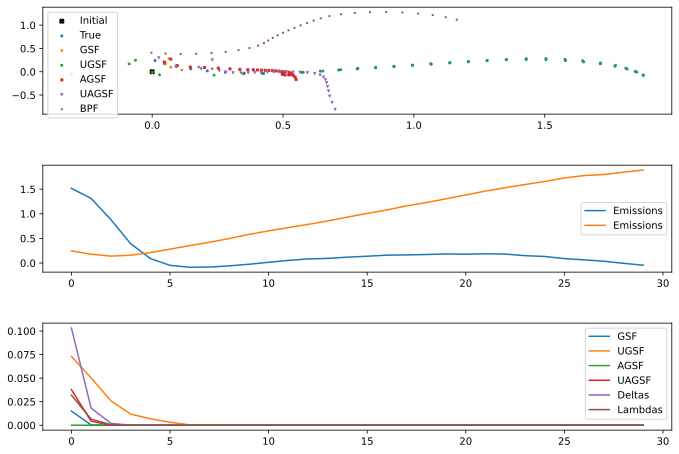

sim 29/100
key0:  [4241594673 2549027846]
key:  [2880162605 1913929932]
       Time taken for GSF:  0.8819839954376221
       Time taken for UGSF:  0.9731907844543457
       Time taken for AGSF:  5.9546959400177
       Time taken for UAGSF:  5.423442840576172
       Time taken for BPF:  0.5395541191101074
              GSF RMSE: 0.020651935
              UGSF RMSE: 0.04255889
              AGSF RMSE: 0.15481764
              UAGSF RMSE: 0.9653628
              BPF RMSE: 0.7251306


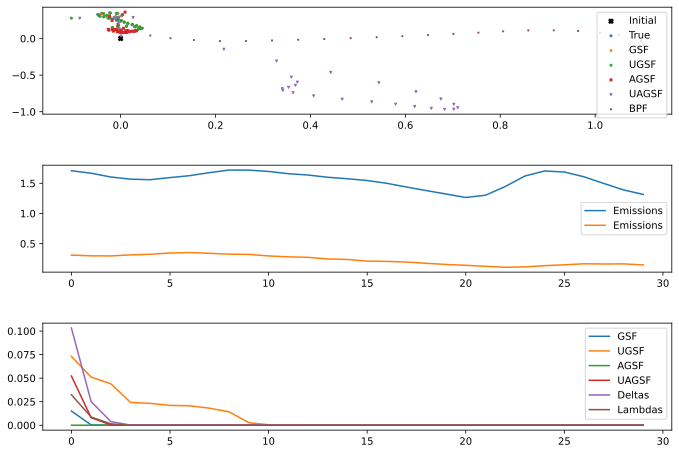

sim 30/100
key0:  [4127811398 1827045953]
key:  [2836373118 2003878861]
       Time taken for GSF:  0.8707551956176758
       Time taken for UGSF:  0.9732739925384521
       Time taken for AGSF:  5.109190225601196
       Time taken for UAGSF:  6.433861017227173
       Time taken for BPF:  0.538891077041626
              GSF RMSE: 0.24666514
              UGSF RMSE: 0.08912735
              AGSF RMSE: 0.35311547
              UAGSF RMSE: 0.21779484
              BPF RMSE: 2.4961019


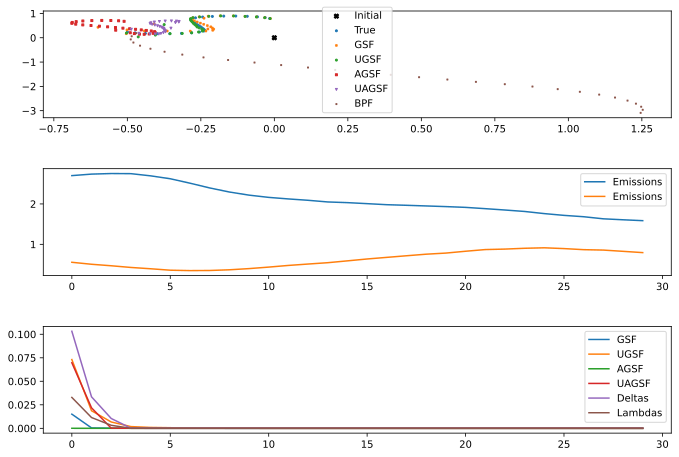

sim 31/100
key0:  [2667547357 3083571703]
key:  [1714563807 3897966836]
       Time taken for GSF:  0.8582980632781982
       Time taken for UGSF:  0.963547945022583
       Time taken for AGSF:  5.122442960739136
       Time taken for UAGSF:  5.404560804367065
       Time taken for BPF:  0.5428838729858398
              GSF RMSE: 0.024258686
              UGSF RMSE: 0.06954324
              AGSF RMSE: 0.8584303
              UAGSF RMSE: 0.9642706
              BPF RMSE: 1.7291377


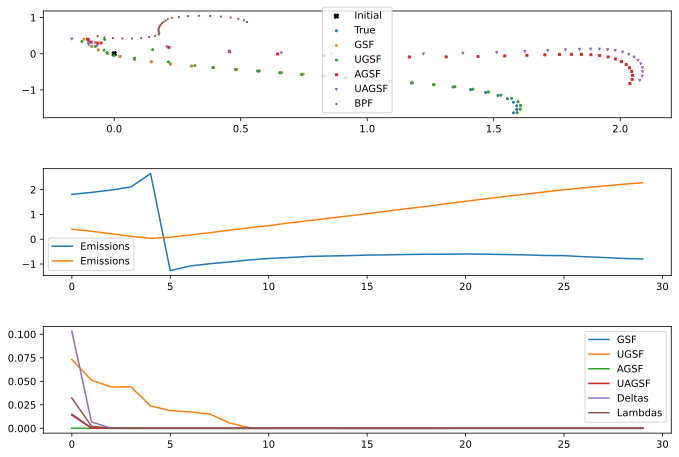

sim 32/100
key0:  [4097068318 3279476549]
key:  [ 66919507 666722832]
       Time taken for GSF:  0.8890421390533447
       Time taken for UGSF:  0.9921820163726807
       Time taken for AGSF:  6.28755521774292
       Time taken for UAGSF:  5.183260917663574
       Time taken for BPF:  0.5333459377288818
              GSF RMSE: 0.08631953
              UGSF RMSE: 0.14527106
              AGSF RMSE: 0.866492
              UAGSF RMSE: 1.6600642
              BPF RMSE: 1.6859481


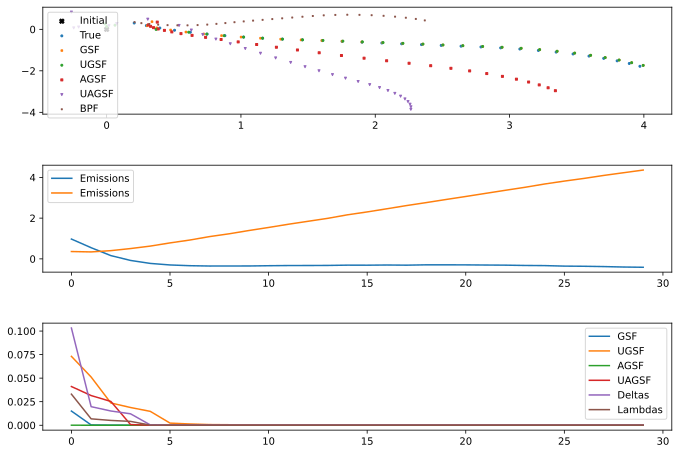

sim 33/100
key0:  [1352548185 3377347842]
key:  [1142431104 4196393820]
       Time taken for GSF:  0.8520886898040771
       Time taken for UGSF:  0.9619688987731934
       Time taken for AGSF:  5.010508060455322
       Time taken for UAGSF:  5.1466591358184814
       Time taken for BPF:  1.6363918781280518
              GSF RMSE: 0.033727366
              UGSF RMSE: 0.034433633
              AGSF RMSE: 1.0169095
              UAGSF RMSE: 1.0809963
              BPF RMSE: 1.8772197


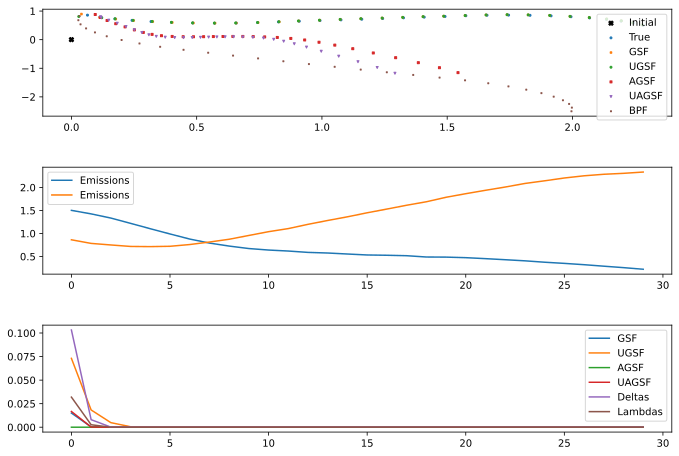

sim 34/100
key0:  [1426702441 1492789755]
key:  [ 550753349 3769041584]
       Time taken for GSF:  0.8476979732513428
       Time taken for UGSF:  0.9546308517456055
       Time taken for AGSF:  4.9676148891448975
       Time taken for UAGSF:  5.168262004852295
       Time taken for BPF:  0.5338387489318848
              GSF RMSE: 0.69391197
              UGSF RMSE: 0.053886164
              AGSF RMSE: 0.45892575
              UAGSF RMSE: 0.4456859
              BPF RMSE: 0.6557669


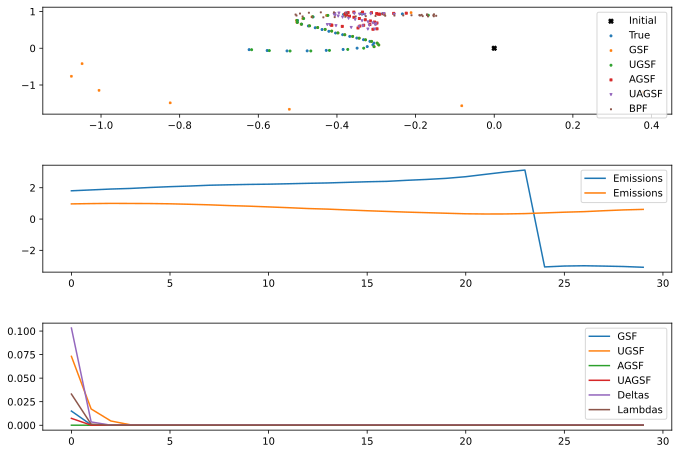

sim 35/100
key0:  [3879714039  537011209]
key:  [701925360 963976890]
       Time taken for GSF:  1.3360240459442139
       Time taken for UGSF:  0.9639148712158203
       Time taken for AGSF:  4.9162821769714355
       Time taken for UAGSF:  6.394953012466431
       Time taken for BPF:  0.5437371730804443
              GSF RMSE: 0.028346261
              UGSF RMSE: 0.037953295
              AGSF RMSE: 0.77470815
              UAGSF RMSE: 0.9183679
              BPF RMSE: 0.22150525


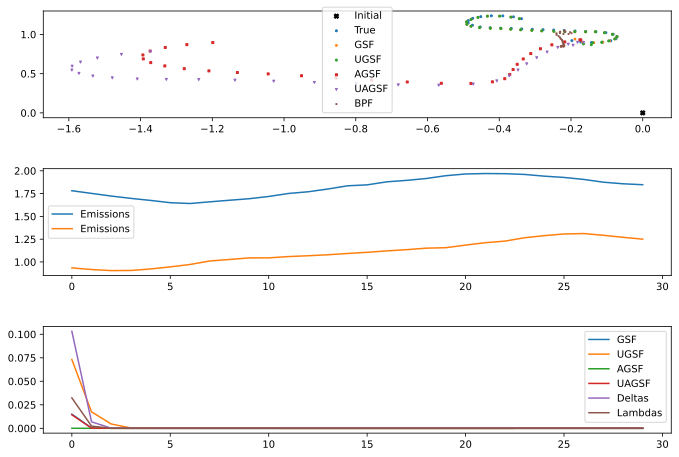

sim 36/100
key0:  [3583935617  858713800]
key:  [3843978566 1916095287]
       Time taken for GSF:  0.8467950820922852
       Time taken for UGSF:  0.9631388187408447
       Time taken for AGSF:  4.968483924865723
       Time taken for UAGSF:  5.143588066101074
       Time taken for BPF:  0.533048152923584
              GSF RMSE: 0.03685527
              UGSF RMSE: 0.0476932
              AGSF RMSE: 0.089492306
              UAGSF RMSE: 0.18345831
              BPF RMSE: 0.2787396


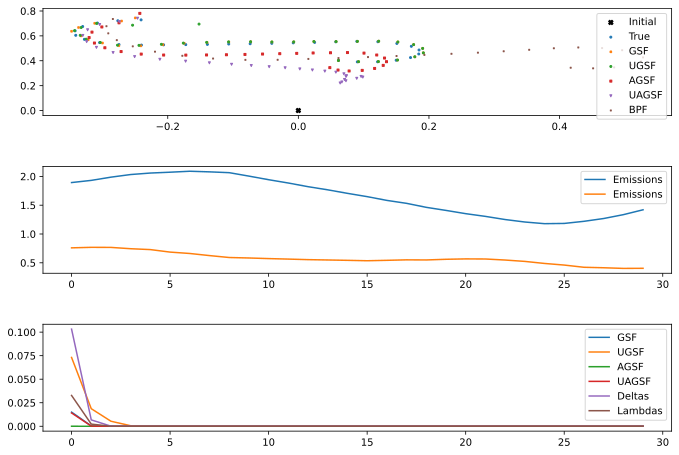

sim 37/100
key0:  [1381516244 1378949135]
key:  [4090523957 2903795642]
       Time taken for GSF:  0.8574740886688232
       Time taken for UGSF:  0.9638800621032715
       Time taken for AGSF:  6.202908039093018
       Time taken for UAGSF:  5.121145009994507
       Time taken for BPF:  0.533566951751709
              GSF RMSE: 0.02858011
              UGSF RMSE: 0.032774188
              AGSF RMSE: 0.87047756
              UAGSF RMSE: 0.53091323
              BPF RMSE: 0.13840702


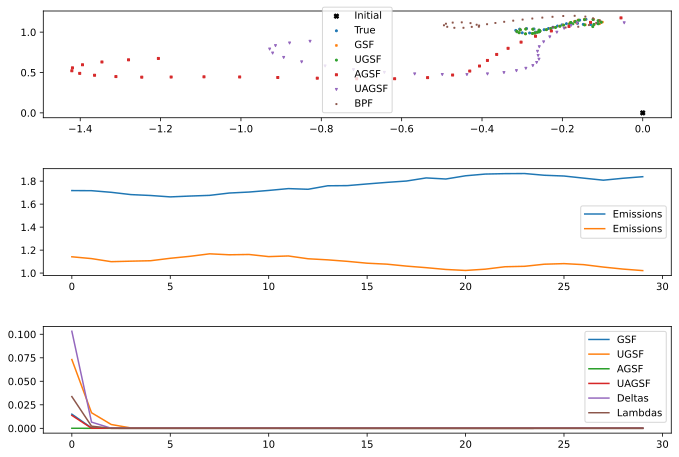

sim 38/100
key0:  [    795349 3626361155]
key:  [2060698472 1935421892]
       Time taken for GSF:  0.8510222434997559
       Time taken for UGSF:  0.9526388645172119
       Time taken for AGSF:  4.9549560546875
       Time taken for UAGSF:  4.940664052963257
       Time taken for BPF:  0.5220208168029785
              GSF RMSE: 0.03437993
              UGSF RMSE: 0.050401177
              AGSF RMSE: 0.3738798
              UAGSF RMSE: 0.12454536
              BPF RMSE: 0.17782773


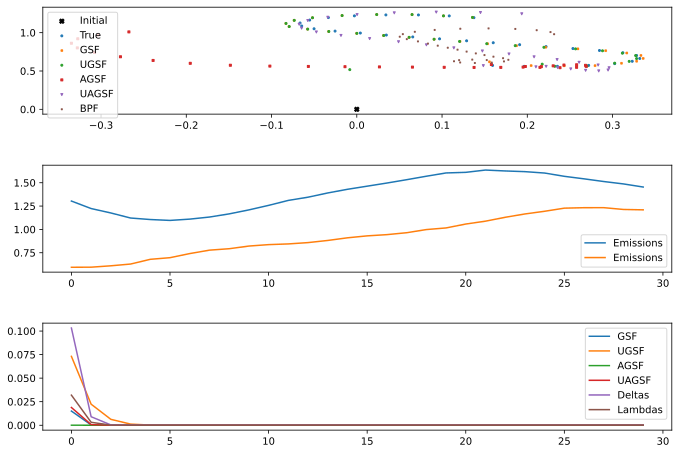

sim 39/100
key0:  [1443475802 1513503680]
key:  [3461804228 1821501735]
       Time taken for GSF:  2.1594560146331787
       Time taken for UGSF:  0.9531760215759277
       Time taken for AGSF:  4.968497276306152
       Time taken for UAGSF:  5.193588972091675
       Time taken for BPF:  0.5334749221801758
              GSF RMSE: 0.042823553
              UGSF RMSE: 0.055166166
              AGSF RMSE: 0.34785455
              UAGSF RMSE: 0.48024076
              BPF RMSE: 1.1136549


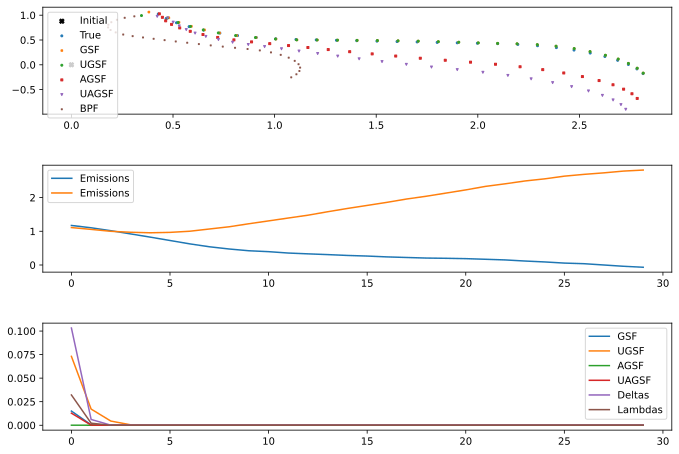

sim 40/100
key0:  [3293209344  859638991]
key:  [2095245717  513504677]
       Time taken for GSF:  0.8521437644958496
       Time taken for UGSF:  0.9562971591949463
       Time taken for AGSF:  4.954061985015869
       Time taken for UAGSF:  5.153164863586426
       Time taken for BPF:  1.8665900230407715
              GSF RMSE: 0.026225131
              UGSF RMSE: 0.036646366
              AGSF RMSE: 1.2981577
              UAGSF RMSE: 0.6896817
              BPF RMSE: 0.7425527


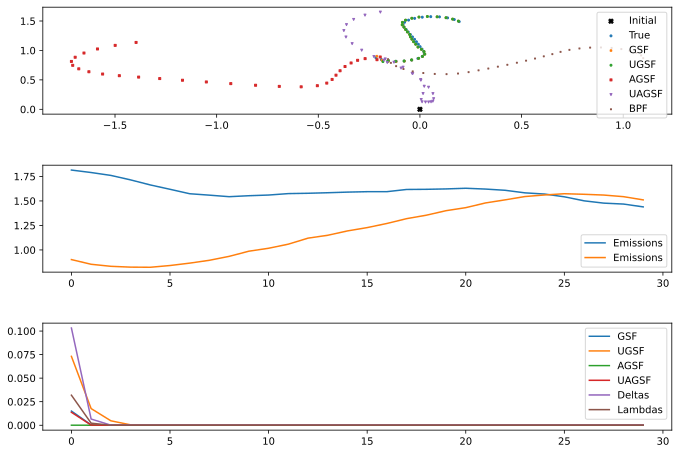

sim 41/100
key0:  [ 135286280 1686744072]
key:  [ 809419074 2446151527]
       Time taken for GSF:  0.8362240791320801
       Time taken for UGSF:  0.9500100612640381
       Time taken for AGSF:  4.889425039291382
       Time taken for UAGSF:  5.154007196426392
       Time taken for BPF:  0.5514202117919922
              GSF RMSE: 0.037070036
              UGSF RMSE: 0.070494965
              AGSF RMSE: 0.44680968
              UAGSF RMSE: 0.7272403
              BPF RMSE: 1.3150823


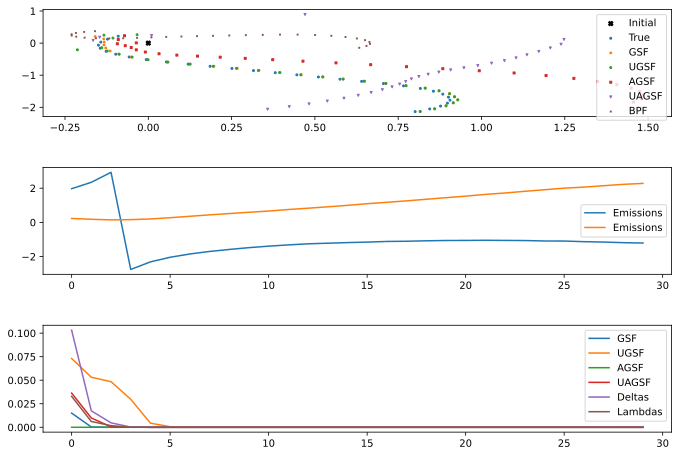

sim 42/100
key0:  [2946973044  706253099]
key:  [2903432635 1884464422]
       Time taken for GSF:  0.8153970241546631
       Time taken for UGSF:  0.9024240970611572
       Time taken for AGSF:  4.6470770835876465
       Time taken for UAGSF:  106.88891196250916
       Time taken for BPF:  0.5082628726959229
              GSF RMSE: 0.06564172
              UGSF RMSE: 0.06674837
              AGSF RMSE: 0.4636949
              UAGSF RMSE: 0.46910676
              BPF RMSE: 0.7433058


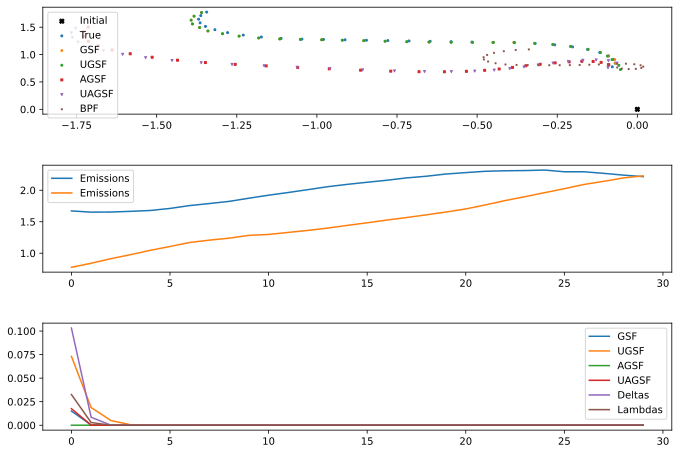

sim 43/100
key0:  [2964417844    5936222]
key:  [1446088450 2397721984]
       Time taken for GSF:  0.852081298828125
       Time taken for UGSF:  0.9622159004211426
       Time taken for AGSF:  5.618847846984863
       Time taken for UAGSF:  5.238306045532227
       Time taken for BPF:  0.5409150123596191
              GSF RMSE: 0.04680566
              UGSF RMSE: 0.039309274
              AGSF RMSE: 0.5675608
              UAGSF RMSE: 0.6002479
              BPF RMSE: 1.6540539


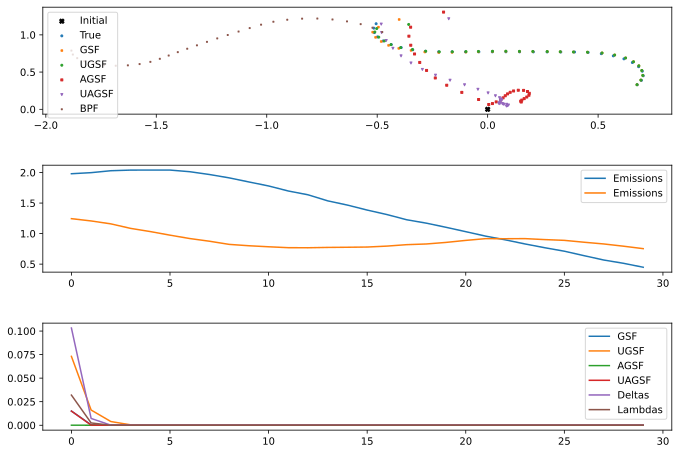

sim 44/100
key0:  [1289099435 4263145636]
key:  [4215328939  815994393]
       Time taken for GSF:  0.8701257705688477
       Time taken for UGSF:  0.9979612827301025
       Time taken for AGSF:  4.929437875747681
       Time taken for UAGSF:  6.98392391204834
       Time taken for BPF:  0.5374751091003418
              GSF RMSE: 0.04449651
              UGSF RMSE: 0.057661638
              AGSF RMSE: 0.826627
              UAGSF RMSE: 1.0001236
              BPF RMSE: 2.1519625


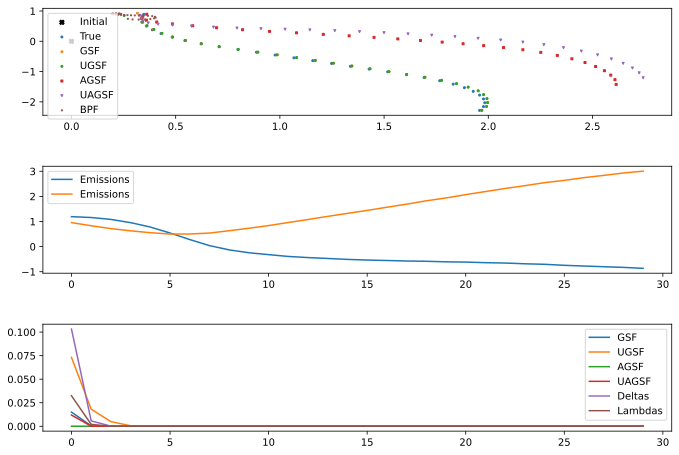

sim 45/100
key0:  [3488432680 1478598887]
key:  [1483610594  482253136]
       Time taken for GSF:  0.872704029083252
       Time taken for UGSF:  0.9735040664672852
       Time taken for AGSF:  4.972100019454956
       Time taken for UAGSF:  5.165212869644165
       Time taken for BPF:  0.5336558818817139
              GSF RMSE: 0.037942242
              UGSF RMSE: 0.0433219
              AGSF RMSE: 2.7081213
              UAGSF RMSE: 2.3895128
              BPF RMSE: 0.26097938


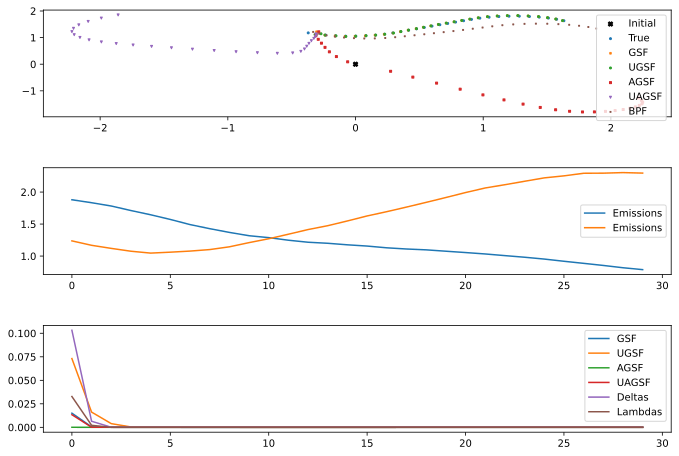

sim 46/100
key0:  [3257233935 1952231522]
key:  [ 929230699 3344410934]
       Time taken for GSF:  0.8647959232330322
       Time taken for UGSF:  0.9626162052154541
       Time taken for AGSF:  4.984431028366089
       Time taken for UAGSF:  5.169583082199097
       Time taken for BPF:  0.5439291000366211
              GSF RMSE: 0.03245421
              UGSF RMSE: 0.037259262
              AGSF RMSE: 0.3431455
              UAGSF RMSE: 0.40852243
              BPF RMSE: 0.20077471


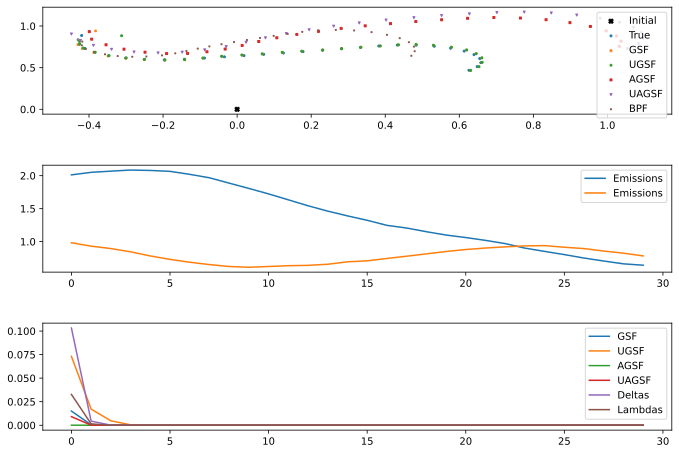

sim 47/100
key0:  [445797803 521715105]
key:  [1593000320  811188585]
       Time taken for GSF:  2.493508815765381
       Time taken for UGSF:  0.9731960296630859
       Time taken for AGSF:  5.052858829498291
       Time taken for UAGSF:  5.44045877456665
       Time taken for BPF:  0.5491580963134766
              GSF RMSE: 0.01839569
              UGSF RMSE: 0.023491666
              AGSF RMSE: 0.7424583
              UAGSF RMSE: 1.1218
              BPF RMSE: 0.7212524


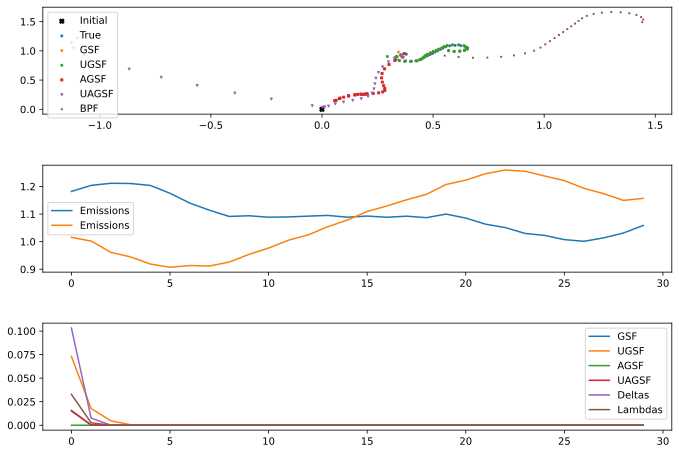

sim 48/100
key0:  [ 851777578 3595087810]
key:  [3647434706 1867762507]
       Time taken for GSF:  0.85477614402771
       Time taken for UGSF:  0.9732449054718018
       Time taken for AGSF:  4.973083734512329
       Time taken for UAGSF:  5.244002103805542
       Time taken for BPF:  0.5356569290161133
              GSF RMSE: 0.036797702
              UGSF RMSE: 0.056930017
              AGSF RMSE: 2.158577
              UAGSF RMSE: 1.489708
              BPF RMSE: 2.0105064


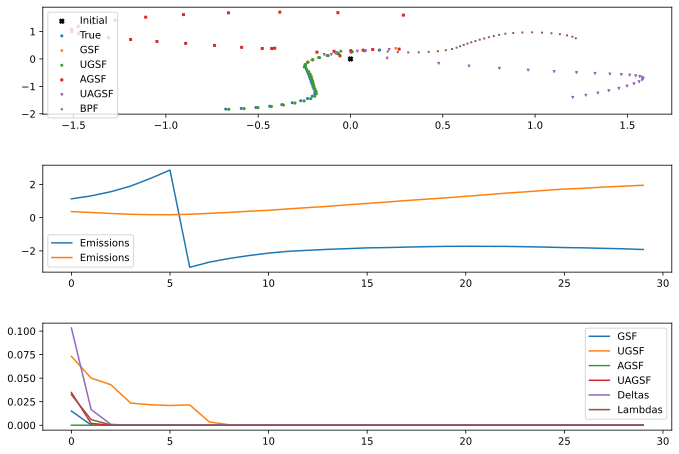

sim 49/100
key0:  [ 183218508 3553746893]
key:  [1232465061  595698750]
       Time taken for GSF:  0.8743860721588135
       Time taken for UGSF:  0.9633238315582275
       Time taken for AGSF:  6.93682599067688
       Time taken for UAGSF:  5.20207405090332
       Time taken for BPF:  0.5404107570648193
              GSF RMSE: 0.05870891
              UGSF RMSE: 0.055126283
              AGSF RMSE: 0.174734
              UAGSF RMSE: 0.16941446
              BPF RMSE: 0.6810576


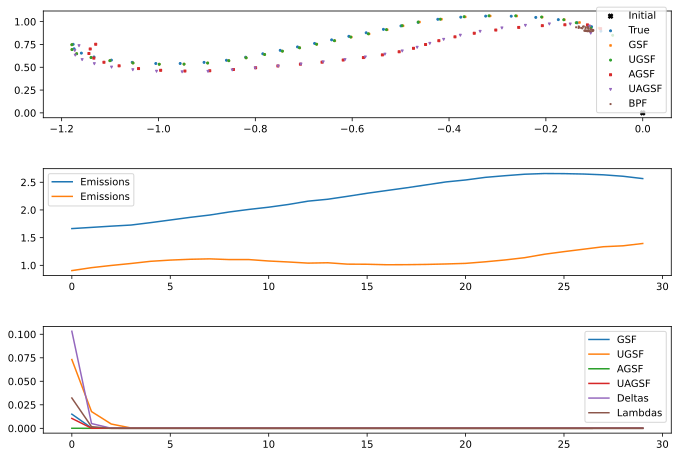

sim 50/100
key0:  [3343796599 1184364315]
key:  [1252721719  809124761]
       Time taken for GSF:  0.8450560569763184
       Time taken for UGSF:  0.978766918182373
       Time taken for AGSF:  4.999024868011475
       Time taken for UAGSF:  5.238905906677246
       Time taken for BPF:  0.5422170162200928
              GSF RMSE: 0.027862074
              UGSF RMSE: 0.03366978
              AGSF RMSE: 0.30237725
              UAGSF RMSE: 0.4007917
              BPF RMSE: 0.22095811


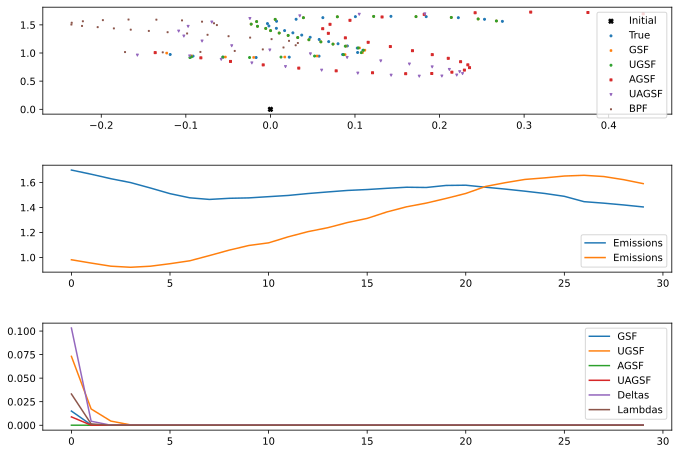

sim 51/100
key0:  [3381932131 2472650865]
key:  [2175510096 1484791526]
       Time taken for GSF:  1.3984062671661377
       Time taken for UGSF:  1.072925090789795
       Time taken for AGSF:  5.111475944519043
       Time taken for UAGSF:  7.481277942657471
       Time taken for BPF:  0.5578892230987549
              GSF RMSE: 0.047573805
              UGSF RMSE: 0.054785494
              AGSF RMSE: 0.10740987
              UAGSF RMSE: 0.17684026
              BPF RMSE: 0.69657654


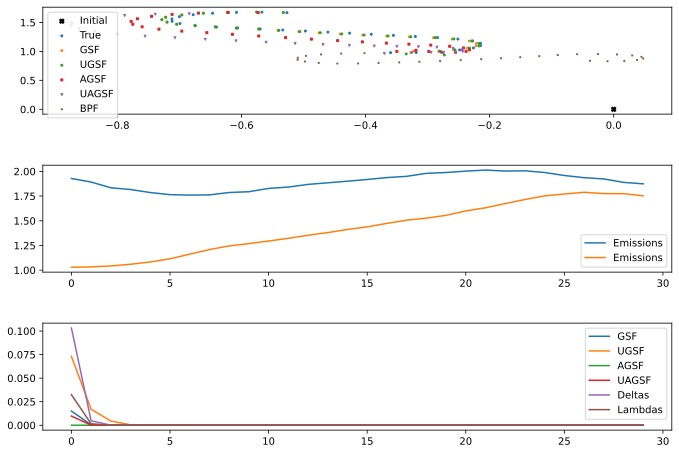

sim 52/100
key0:  [ 130718858 2352678943]
key:  [1299744928 2761854373]
       Time taken for GSF:  0.9081690311431885
       Time taken for UGSF:  0.9903759956359863
       Time taken for AGSF:  5.0634589195251465
       Time taken for UAGSF:  5.2279229164123535
       Time taken for BPF:  0.5385708808898926
              GSF RMSE: 0.084329486
              UGSF RMSE: 0.05098193
              AGSF RMSE: 0.294755
              UAGSF RMSE: 0.2778289
              BPF RMSE: 0.1571127


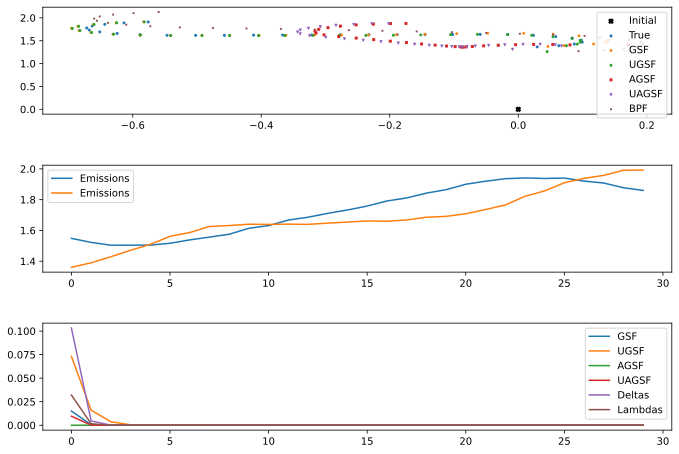

sim 53/100
key0:  [1093701459  347181194]
key:  [3860313114 1934098228]
       Time taken for GSF:  0.8828432559967041
       Time taken for UGSF:  0.9749050140380859
       Time taken for AGSF:  4.846907138824463
       Time taken for UAGSF:  5.207496166229248
       Time taken for BPF:  0.5374150276184082
              GSF RMSE: 0.03650411
              UGSF RMSE: 0.04454696
              AGSF RMSE: 0.50200826
              UAGSF RMSE: 0.83961934
              BPF RMSE: 0.31872964


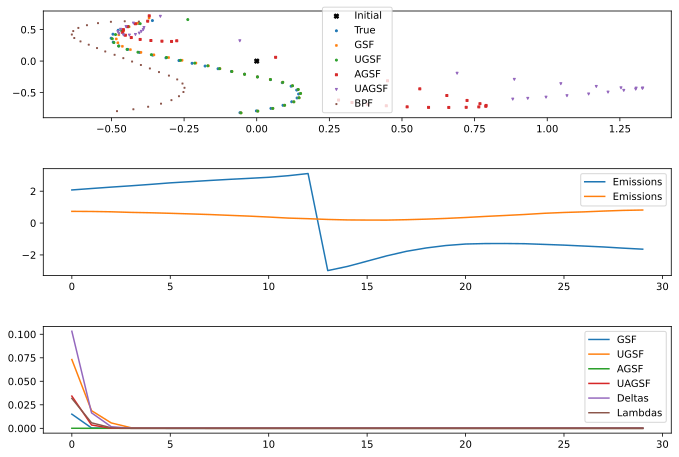

sim 54/100
key0:  [2878158215 3784790468]
key:  [2611459947  489075845]
       Time taken for GSF:  0.8831849098205566
       Time taken for UGSF:  0.9852499961853027
       Time taken for AGSF:  7.0668721199035645
       Time taken for UAGSF:  5.261792898178101
       Time taken for BPF:  0.5518798828125
              GSF RMSE: 0.04060431
              UGSF RMSE: 0.049933966
              AGSF RMSE: 0.5341965
              UAGSF RMSE: 0.95163643
              BPF RMSE: 1.3715626


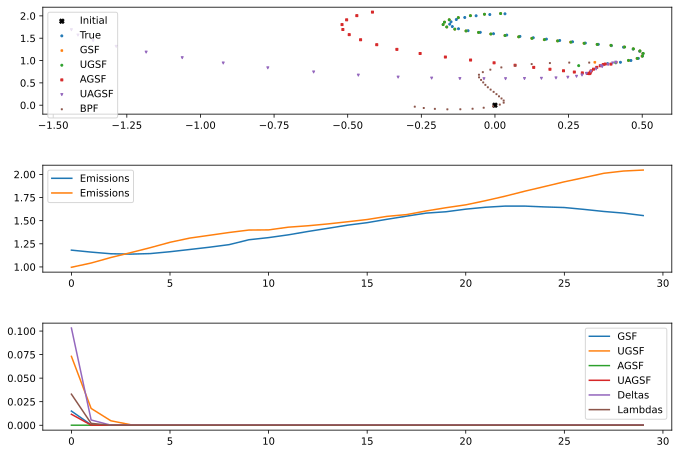

sim 55/100
key0:  [1423747144 3160601483]
key:  [1088751577  319449869]
       Time taken for GSF:  0.878760814666748
       Time taken for UGSF:  0.9846651554107666
       Time taken for AGSF:  5.025482892990112
       Time taken for UAGSF:  5.247887134552002
       Time taken for BPF:  0.5899357795715332
              GSF RMSE: 0.040394515
              UGSF RMSE: 0.039057333
              AGSF RMSE: 1.2617022
              UAGSF RMSE: 0.92340976
              BPF RMSE: 0.53018117


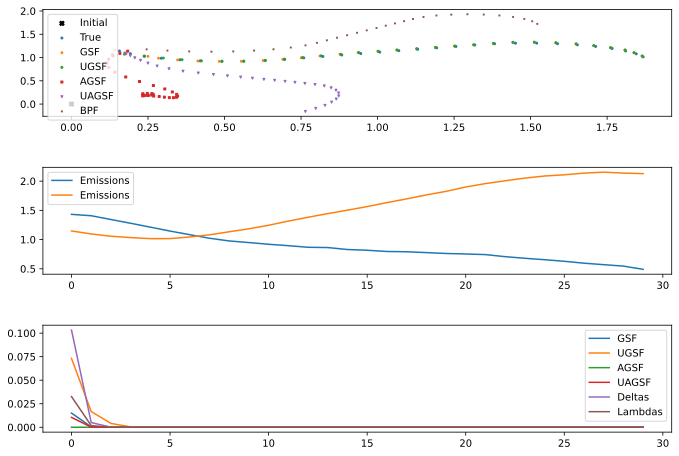

sim 56/100
key0:  [ 176956694 3442584173]
key:  [1816131912 2839293455]
       Time taken for GSF:  0.9397146701812744
       Time taken for UGSF:  1.042341947555542
       Time taken for AGSF:  5.123220205307007
       Time taken for UAGSF:  7.549526214599609
       Time taken for BPF:  0.5525000095367432
              GSF RMSE: 0.03907421
              UGSF RMSE: 0.04705599
              AGSF RMSE: 0.561626
              UAGSF RMSE: 0.59173924
              BPF RMSE: 1.5051198


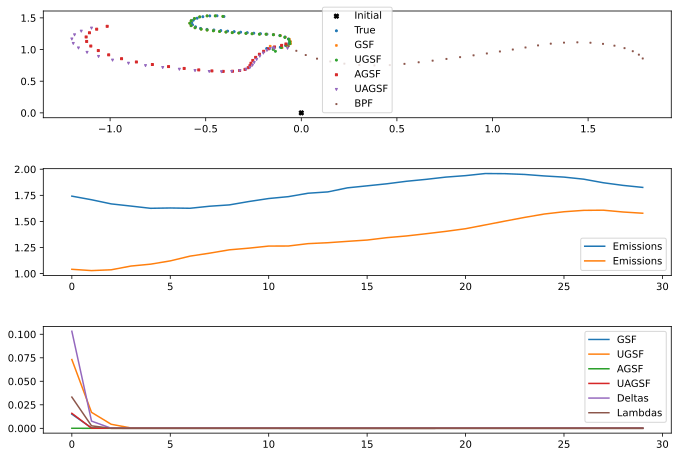

sim 57/100
key0:  [3392008150 1726277541]
key:  [1611190576 1974266124]
       Time taken for GSF:  0.91109299659729
       Time taken for UGSF:  0.9886031150817871
       Time taken for AGSF:  4.836544036865234
       Time taken for UAGSF:  5.098935127258301
       Time taken for BPF:  0.5268399715423584
              GSF RMSE: 0.05355313
              UGSF RMSE: 0.06386828
              AGSF RMSE: 0.5820572
              UAGSF RMSE: 0.53931516
              BPF RMSE: 0.43978095


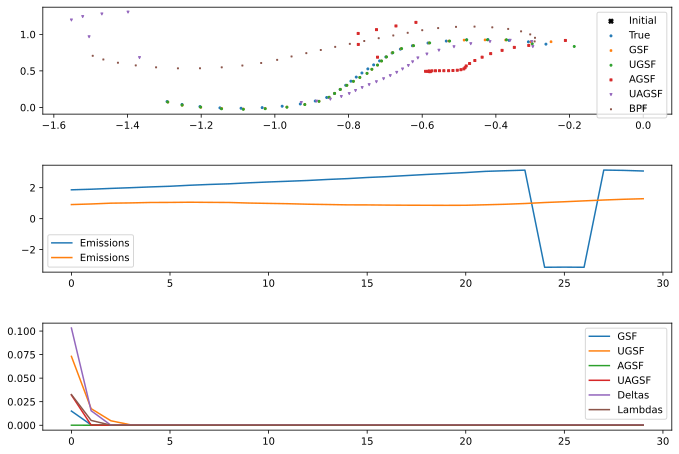

sim 58/100
key0:  [2476375293 3756013201]
key:  [3539195822  322384264]
       Time taken for GSF:  1.329267978668213
       Time taken for UGSF:  1.325052261352539
       Time taken for AGSF:  4.952438116073608
       Time taken for UAGSF:  5.561254978179932
       Time taken for BPF:  0.5669090747833252
              GSF RMSE: 0.025847895
              UGSF RMSE: 0.05145982
              AGSF RMSE: 0.1393948
              UAGSF RMSE: 0.16166738
              BPF RMSE: 0.24807887


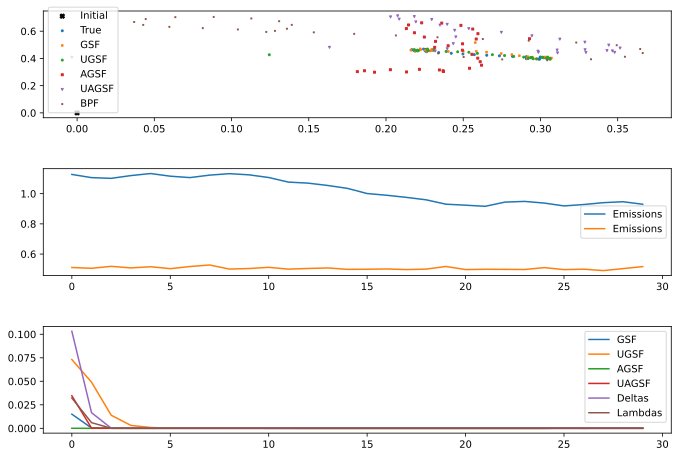

sim 59/100
key0:  [2481040864 2609313738]
key:  [2984320191 3303220167]
       Time taken for GSF:  1.0040099620819092
       Time taken for UGSF:  1.033926010131836
       Time taken for AGSF:  7.423641681671143
       Time taken for UAGSF:  5.389559030532837
       Time taken for BPF:  0.5847499370574951
              GSF RMSE: 0.5170112
              UGSF RMSE: 0.10367796
              AGSF RMSE: 2.4655669
              UAGSF RMSE: 1.7689996
              BPF RMSE: 0.9058428


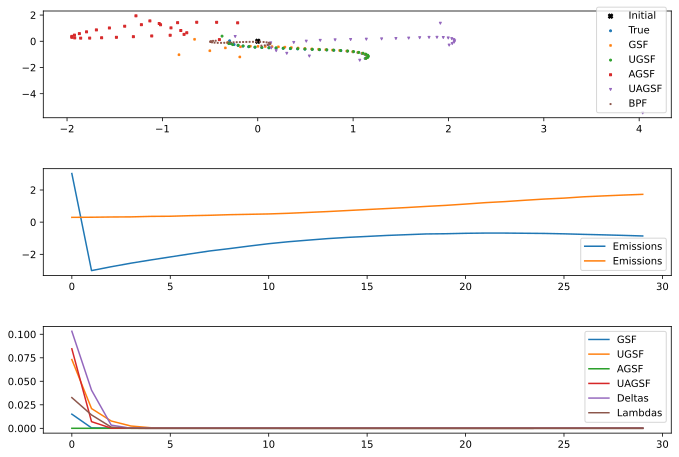

sim 60/100
key0:  [ 975156671 1624514521]
key:  [ 780669193 4231224228]
       Time taken for GSF:  1.0166969299316406
       Time taken for UGSF:  1.0654089450836182
       Time taken for AGSF:  5.554130792617798
       Time taken for UAGSF:  5.6903650760650635
       Time taken for BPF:  0.5921881198883057
              GSF RMSE: 0.039317034
              UGSF RMSE: 0.030987408
              AGSF RMSE: 0.1461289
              UAGSF RMSE: 0.25720674
              BPF RMSE: 0.33828753


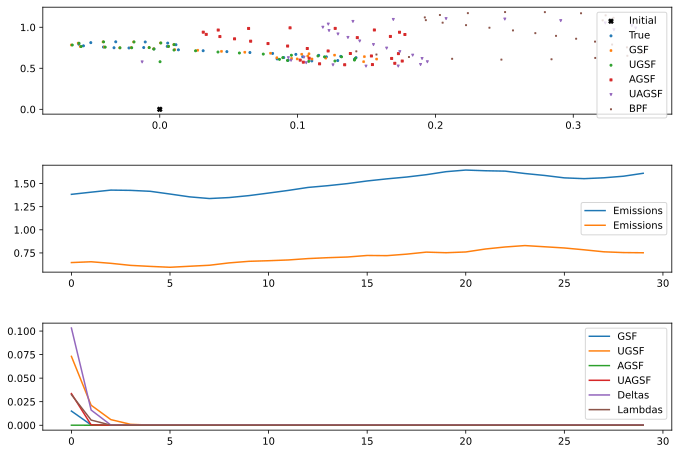

sim 61/100
key0:  [1064902070 2730719367]
key:  [  15283692 3968166679]
       Time taken for GSF:  1.0414090156555176
       Time taken for UGSF:  1.0996580123901367
       Time taken for AGSF:  5.563321113586426
       Time taken for UAGSF:  5.657658815383911
       Time taken for BPF:  0.5577740669250488
              GSF RMSE: 0.02252973
              UGSF RMSE: 0.04706489
              AGSF RMSE: 0.23184595
              UAGSF RMSE: 0.34311244
              BPF RMSE: 0.40171537


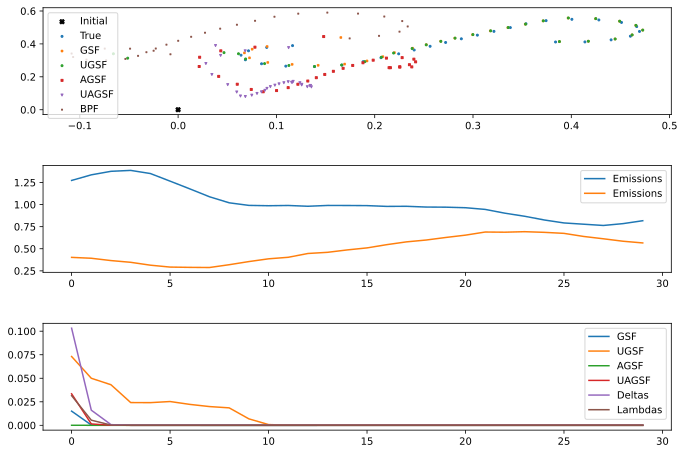

sim 62/100
key0:  [ 889232618 3175102760]
key:  [4044479483 2856481839]
       Time taken for GSF:  0.9197731018066406
       Time taken for UGSF:  1.0183839797973633
       Time taken for AGSF:  7.599422931671143
       Time taken for UAGSF:  5.761771202087402
       Time taken for BPF:  0.6018218994140625
              GSF RMSE: 0.038285088
              UGSF RMSE: 0.045110673
              AGSF RMSE: 0.8477065
              UAGSF RMSE: 0.8458502
              BPF RMSE: 0.4005106


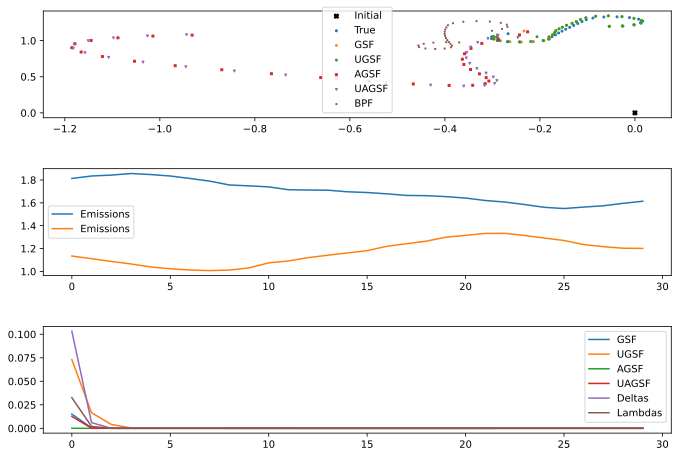

sim 63/100
key0:  [904012501 348926164]
key:  [834529741 350132673]
       Time taken for GSF:  0.9885621070861816
       Time taken for UGSF:  1.0105462074279785
       Time taken for AGSF:  5.094035387039185
       Time taken for UAGSF:  5.499856948852539
       Time taken for BPF:  0.574138879776001
              GSF RMSE: nan
              UGSF RMSE: 0.052930996
              AGSF RMSE: 0.77136606
              UAGSF RMSE: 1.1489886
              BPF RMSE: 1.3610202


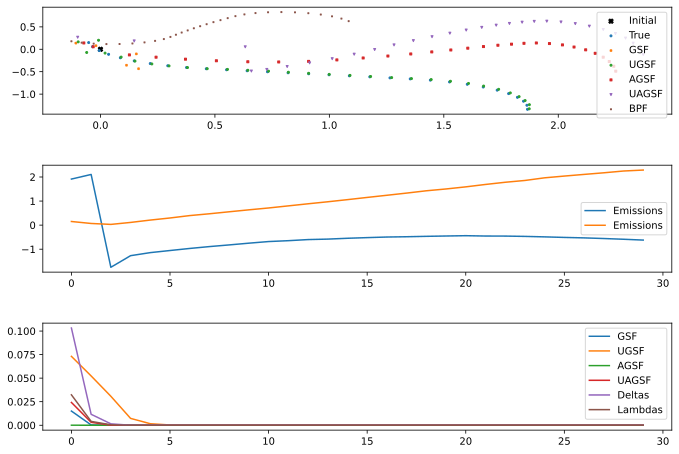

sim 64/100
key0:  [3757085292  912647599]
key:  [ 357705266 2563541628]
       Time taken for GSF:  0.9403030872344971
       Time taken for UGSF:  1.0344722270965576
       Time taken for AGSF:  5.186133861541748
       Time taken for UAGSF:  5.441487073898315
       Time taken for BPF:  0.5658540725708008
              GSF RMSE: 0.10149526
              UGSF RMSE: 0.07357703
              AGSF RMSE: 0.8037783
              UAGSF RMSE: 0.9626438
              BPF RMSE: 0.6904134


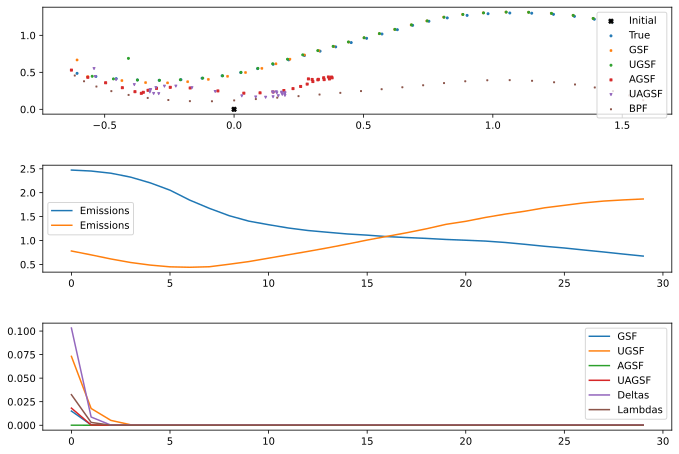

sim 65/100
key0:  [ 661572511 4218224004]
key:  [2791900570   26459955]
       Time taken for GSF:  0.933419942855835
       Time taken for UGSF:  1.0281641483306885
       Time taken for AGSF:  8.2999107837677
       Time taken for UAGSF:  5.6546831130981445
       Time taken for BPF:  0.5832700729370117
              GSF RMSE: 0.056328602
              UGSF RMSE: 0.053302646
              AGSF RMSE: 0.26832595
              UAGSF RMSE: 0.2227183
              BPF RMSE: 0.5401641


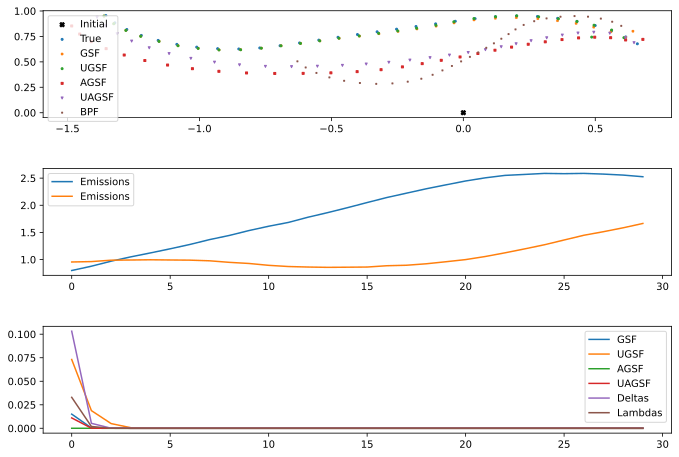

sim 66/100
key0:  [3427393284 2281600490]
key:  [2502352421  386484703]
       Time taken for GSF:  1.0050952434539795
       Time taken for UGSF:  1.0544819831848145
       Time taken for AGSF:  5.49404501914978
       Time taken for UAGSF:  5.679868936538696
       Time taken for BPF:  0.5840330123901367
              GSF RMSE: 0.08081118
              UGSF RMSE: 0.065251485
              AGSF RMSE: 2.9784098
              UAGSF RMSE: 3.2936122
              BPF RMSE: 0.27154338


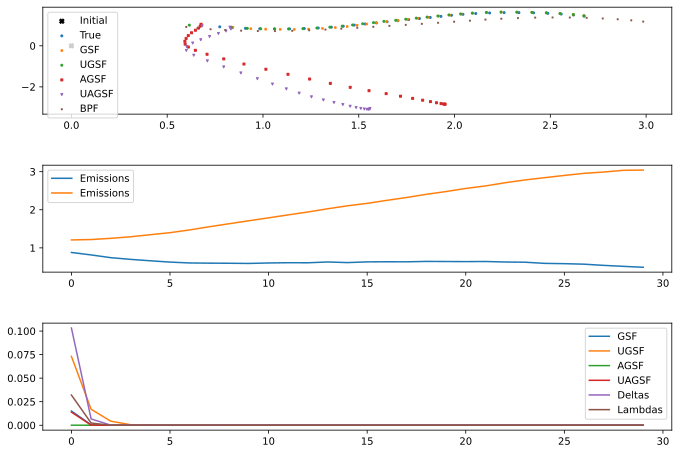

sim 67/100
key0:  [4216753897 3437139068]
key:  [2421089496  825359818]
       Time taken for GSF:  1.0502080917358398
       Time taken for UGSF:  1.1250081062316895
       Time taken for AGSF:  5.4509241580963135
       Time taken for UAGSF:  5.64529013633728
       Time taken for BPF:  0.585911750793457
              GSF RMSE: 0.038708255
              UGSF RMSE: 0.05183096
              AGSF RMSE: 0.113796465
              UAGSF RMSE: 0.3253868
              BPF RMSE: 1.3051734


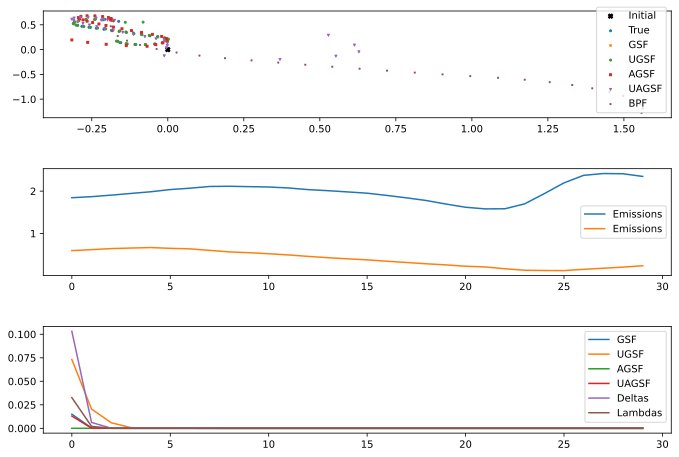

sim 68/100
key0:  [3766128474 2998578151]
key:  [4163432688 1204078184]
       Time taken for GSF:  1.2276673316955566
       Time taken for UGSF:  1.8425202369689941
       Time taken for AGSF:  8.957682847976685
       Time taken for UAGSF:  5.824538946151733
       Time taken for BPF:  0.5952541828155518
              GSF RMSE: 0.03226354
              UGSF RMSE: 0.04359575
              AGSF RMSE: 1.3505116
              UAGSF RMSE: 1.9044926
              BPF RMSE: 1.5904841


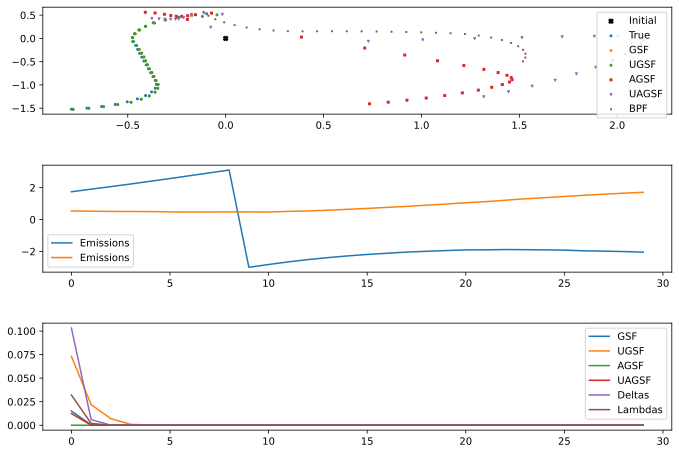

sim 69/100
key0:  [4128623668 4216911137]
key:  [2196032381  770221195]
       Time taken for GSF:  1.054429054260254
       Time taken for UGSF:  1.0743720531463623
       Time taken for AGSF:  5.224252939224243
       Time taken for UAGSF:  5.583033084869385
       Time taken for BPF:  0.6005740165710449
              GSF RMSE: 0.04266163
              UGSF RMSE: 0.04168796
              AGSF RMSE: 0.1439105
              UAGSF RMSE: 0.14610966
              BPF RMSE: 1.1692396


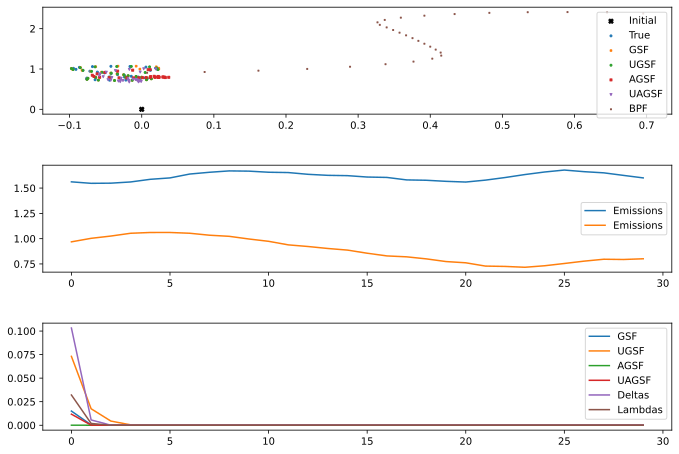

sim 70/100
key0:  [1766853340  992522559]
key:  [3901187291  205450875]
       Time taken for GSF:  1.1980679035186768
       Time taken for UGSF:  1.1035869121551514
       Time taken for AGSF:  5.371671915054321
       Time taken for UAGSF:  5.508923053741455
       Time taken for BPF:  0.5712668895721436
              GSF RMSE: 0.03852861
              UGSF RMSE: 0.044193033
              AGSF RMSE: 0.095889226
              UAGSF RMSE: 0.18649344
              BPF RMSE: 1.9935333


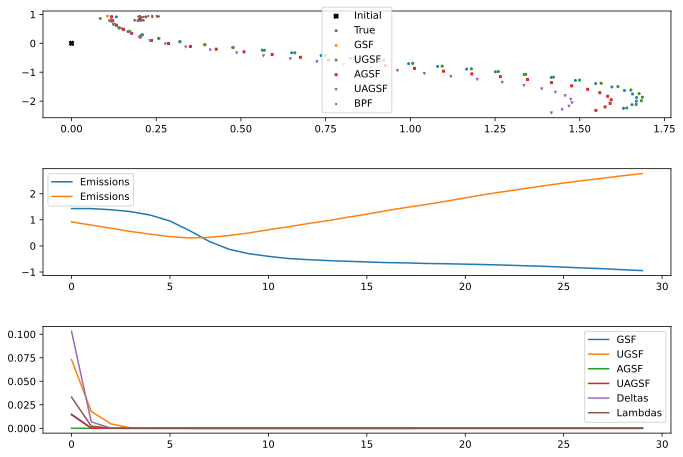

sim 71/100
key0:  [3642009555 1035709618]
key:  [1059844704 2282868745]
       Time taken for GSF:  1.013211727142334
       Time taken for UGSF:  1.098510980606079
       Time taken for AGSF:  8.338201761245728
       Time taken for UAGSF:  5.7077789306640625
       Time taken for BPF:  0.5991852283477783
              GSF RMSE: 0.033223804
              UGSF RMSE: 0.043556787
              AGSF RMSE: 1.0959818
              UAGSF RMSE: 1.0653037
              BPF RMSE: 0.57996565


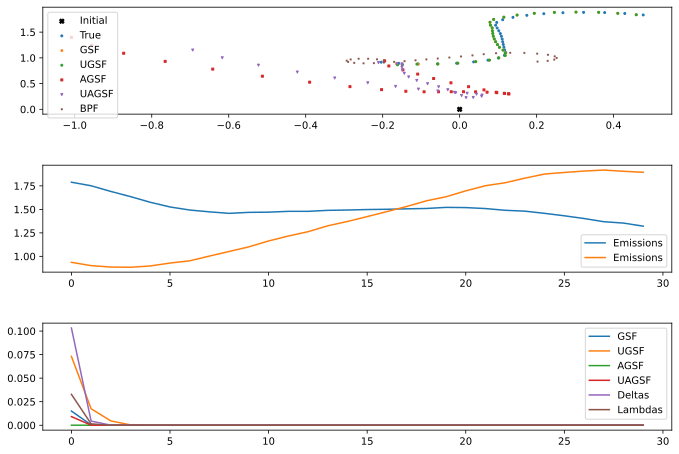

sim 72/100
key0:  [1068985975  103459135]
key:  [1720967730  244030160]
       Time taken for GSF:  1.0151779651641846
       Time taken for UGSF:  1.0503699779510498
       Time taken for AGSF:  5.261180877685547
       Time taken for UAGSF:  5.4663450717926025
       Time taken for BPF:  0.5687758922576904
              GSF RMSE: nan
              UGSF RMSE: 0.06154757
              AGSF RMSE: 0.70670086
              UAGSF RMSE: 1.8076653
              BPF RMSE: 1.3848023


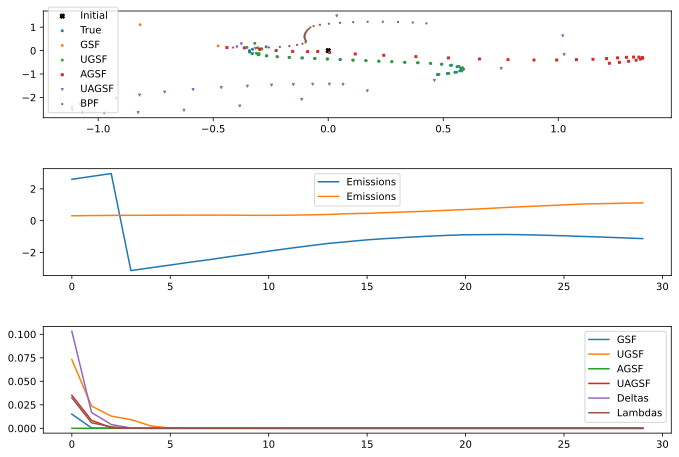

sim 73/100
key0:  [1029100688  852640707]
key:  [2559773278 2083926449]
       Time taken for GSF:  0.9779579639434814
       Time taken for UGSF:  1.0833170413970947
       Time taken for AGSF:  5.102225303649902
       Time taken for UAGSF:  5.635366916656494
       Time taken for BPF:  0.5790688991546631
              GSF RMSE: 0.039541245
              UGSF RMSE: 0.038015205
              AGSF RMSE: 0.38224873
              UAGSF RMSE: 0.38191366
              BPF RMSE: 0.4698368


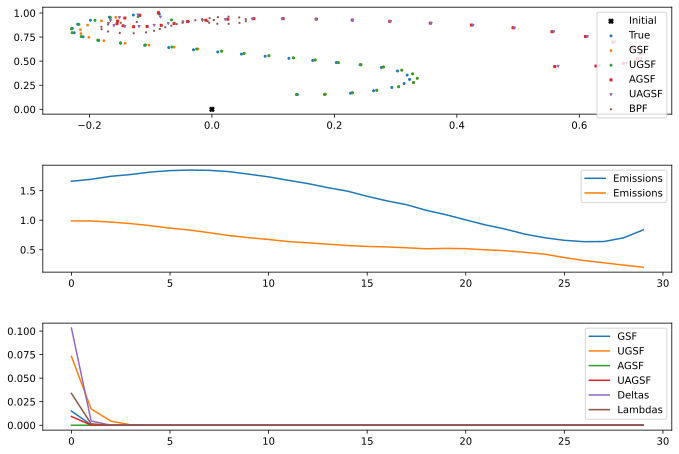

sim 74/100
key0:  [ 63750304 611340893]
key:  [ 130844233 4042254844]
       Time taken for GSF:  1.0592639446258545
       Time taken for UGSF:  1.06787109375
       Time taken for AGSF:  5.3023459911346436
       Time taken for UAGSF:  5.635801792144775
       Time taken for BPF:  4.036094903945923
              GSF RMSE: 0.07486479
              UGSF RMSE: 0.077539206
              AGSF RMSE: 0.3937992
              UAGSF RMSE: 0.5277169
              BPF RMSE: 1.3675256


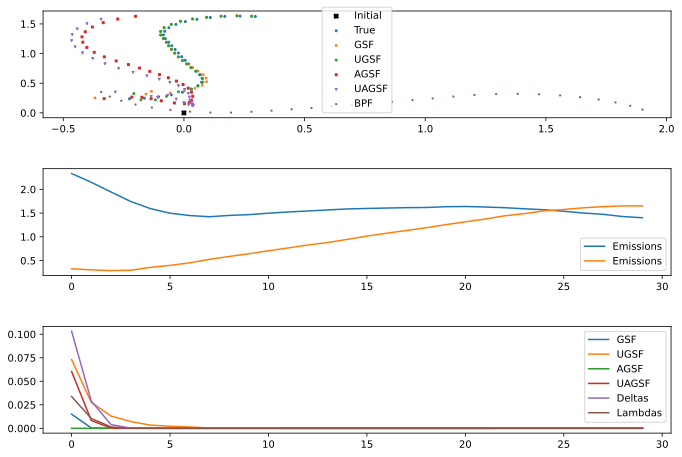

sim 75/100
key0:  [3098906929 2125285375]
key:  [1538347445 2998754256]
       Time taken for GSF:  1.2047791481018066
       Time taken for UGSF:  1.1799280643463135
       Time taken for AGSF:  5.49876594543457
       Time taken for UAGSF:  6.487396955490112
       Time taken for BPF:  0.6284351348876953
              GSF RMSE: 0.030684208
              UGSF RMSE: 0.032673445
              AGSF RMSE: 0.20310359
              UAGSF RMSE: 0.20489249
              BPF RMSE: 0.33439365


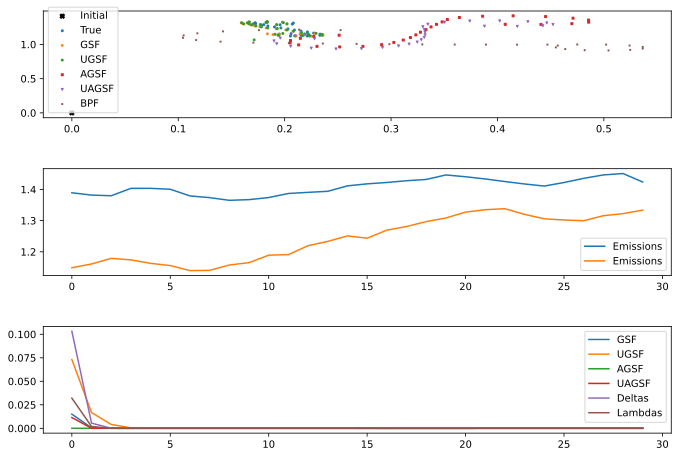

sim 76/100
key0:  [3304678098 2686878888]
key:  [3728752596 1018145908]
       Time taken for GSF:  0.9760251045227051
       Time taken for UGSF:  1.024261236190796
       Time taken for AGSF:  4.931777000427246
       Time taken for UAGSF:  5.450813055038452
       Time taken for BPF:  0.5759930610656738
              GSF RMSE: 0.04456415
              UGSF RMSE: 0.053944524
              AGSF RMSE: 0.45717365
              UAGSF RMSE: 0.46338367
              BPF RMSE: 0.55477643


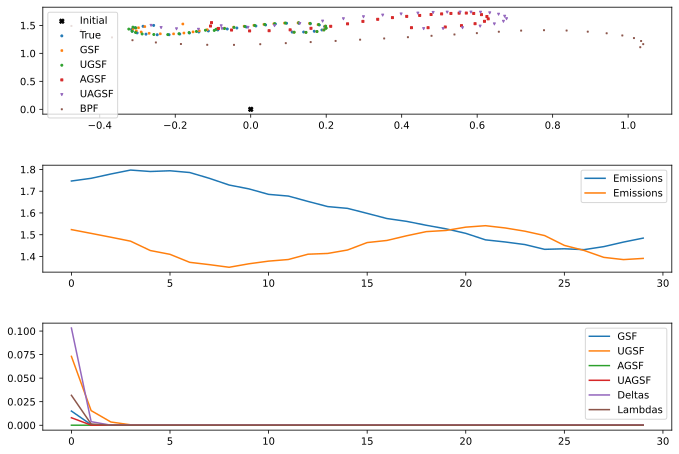

sim 77/100
key0:  [1904848050 1902556246]
key:  [1850405598 2831545586]
       Time taken for GSF:  0.9459149837493896
       Time taken for UGSF:  1.0554931163787842
       Time taken for AGSF:  5.139266014099121
       Time taken for UAGSF:  5.423093795776367
       Time taken for BPF:  0.5849361419677734
              GSF RMSE: 0.031423233
              UGSF RMSE: 0.05540788
              AGSF RMSE: 0.10431033
              UAGSF RMSE: 0.25718153
              BPF RMSE: 0.86429214


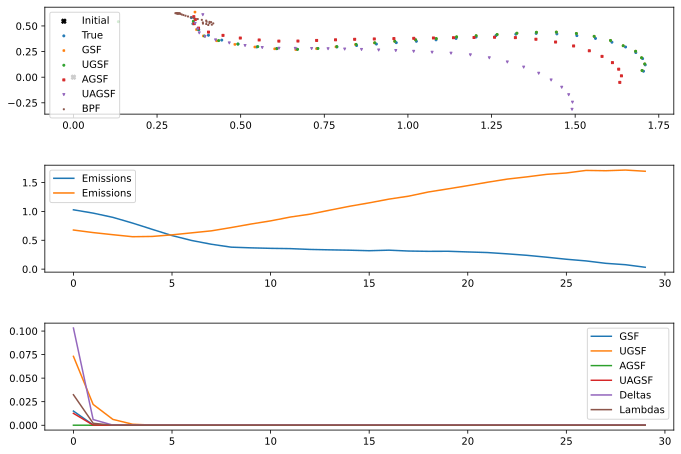

sim 78/100
key0:  [ 33622251 260603537]
key:  [2692549449 3502030742]
       Time taken for GSF:  0.9477698802947998
       Time taken for UGSF:  1.079493761062622
       Time taken for AGSF:  8.604819059371948
       Time taken for UAGSF:  5.470389366149902
       Time taken for BPF:  0.5757882595062256
              GSF RMSE: 0.020106278
              UGSF RMSE: 0.039588135
              AGSF RMSE: 0.14928144
              UAGSF RMSE: 0.06405149
              BPF RMSE: 0.219326


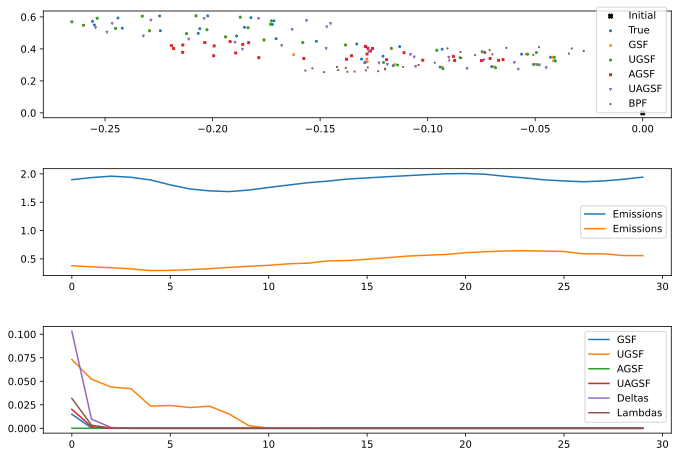

sim 79/100
key0:  [3550834898 3021684562]
key:  [ 169256403 1825228908]
       Time taken for GSF:  0.958953857421875
       Time taken for UGSF:  1.0579302310943604
       Time taken for AGSF:  5.180655241012573
       Time taken for UAGSF:  5.424952030181885
       Time taken for BPF:  0.5784602165222168
              GSF RMSE: nan
              UGSF RMSE: nan
              AGSF RMSE: 1.6385523
              UAGSF RMSE: 1.5661372
              BPF RMSE: 1.887986


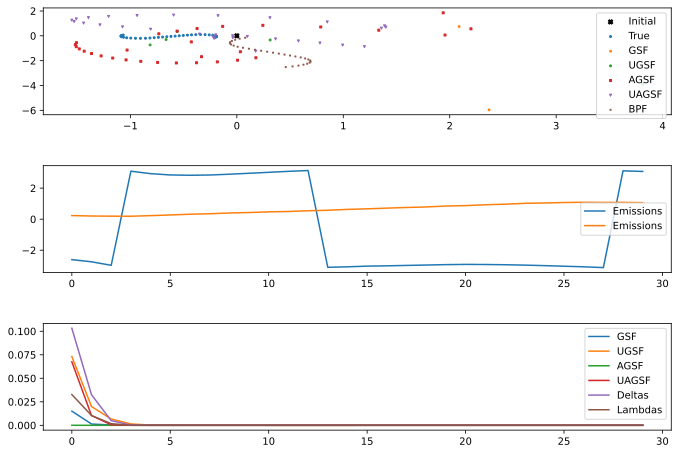

sim 80/100
key0:  [2453036040  750301776]
key:  [1727409852 1122385035]
       Time taken for GSF:  0.9532482624053955
       Time taken for UGSF:  1.065429925918579
       Time taken for AGSF:  5.183686017990112
       Time taken for UAGSF:  5.42995023727417
       Time taken for BPF:  0.5719420909881592
              GSF RMSE: 0.018150428
              UGSF RMSE: 0.02069036
              AGSF RMSE: 0.2376173
              UAGSF RMSE: 0.22994398
              BPF RMSE: 0.5208306


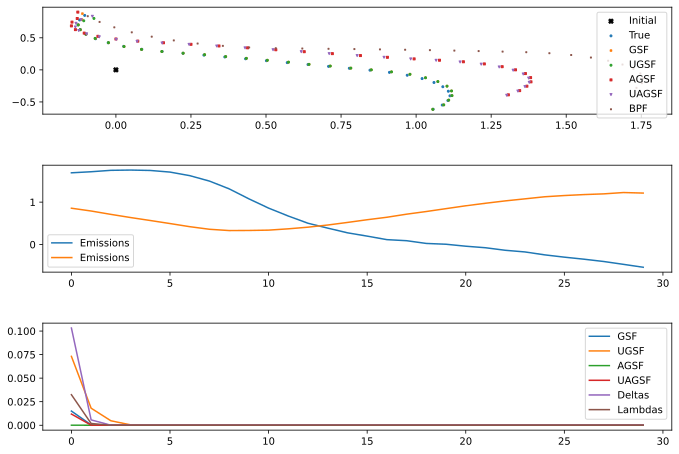

sim 81/100
key0:  [2224467380 2650892616]
key:  [3840433784  223133259]
       Time taken for GSF:  1.017500877380371
       Time taken for UGSF:  1.080212116241455
       Time taken for AGSF:  5.179351806640625
       Time taken for UAGSF:  5.374552965164185
       Time taken for BPF:  0.5878889560699463
              GSF RMSE: 0.06799542
              UGSF RMSE: 0.06387614
              AGSF RMSE: 1.1590263
              UAGSF RMSE: 0.19626991
              BPF RMSE: 0.5177899


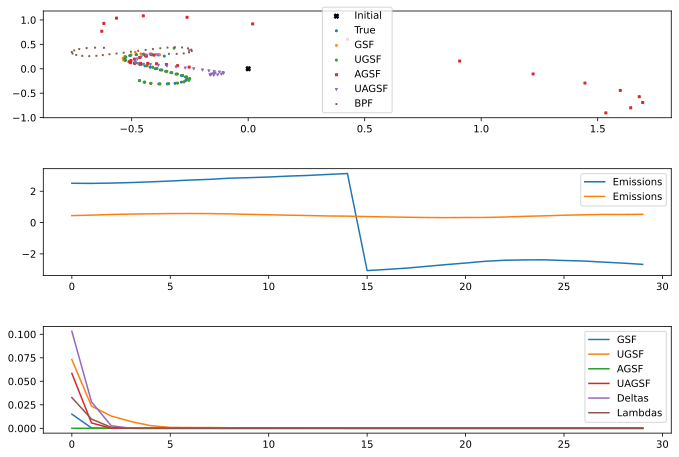

sim 82/100
key0:  [2267320037 2939307473]
key:  [ 995903540 3579019335]
       Time taken for GSF:  0.9728708267211914
       Time taken for UGSF:  4.612335205078125
       Time taken for AGSF:  5.332398176193237
       Time taken for UAGSF:  5.420732259750366
       Time taken for BPF:  0.5740528106689453
              GSF RMSE: 0.07204053
              UGSF RMSE: 0.06621047
              AGSF RMSE: 0.6900785
              UAGSF RMSE: 0.72999555
              BPF RMSE: 1.4868286


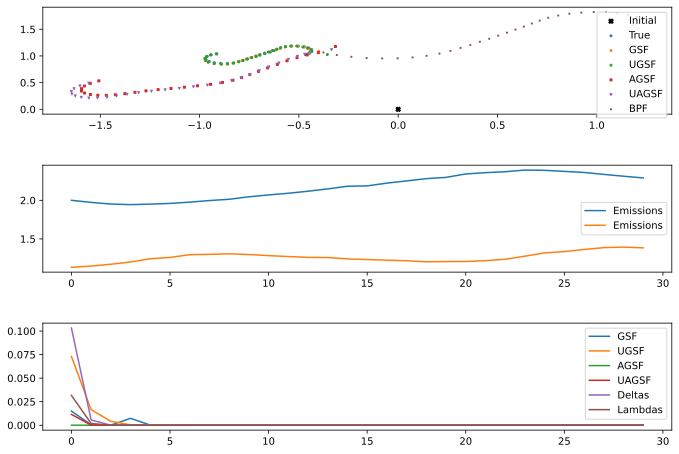

sim 83/100
key0:  [1315200527 2241917959]
key:  [4134790228 3193602026]
       Time taken for GSF:  0.9691519737243652
       Time taken for UGSF:  2.0629262924194336
       Time taken for AGSF:  5.4645161628723145
       Time taken for UAGSF:  5.393196105957031
       Time taken for BPF:  0.5751380920410156
              GSF RMSE: 0.025513953
              UGSF RMSE: 0.031691995
              AGSF RMSE: 1.3743393
              UAGSF RMSE: 1.4711311
              BPF RMSE: 2.0875351


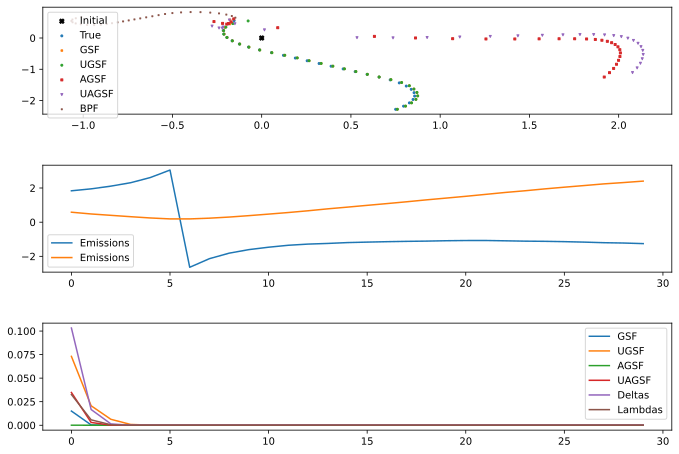

sim 84/100
key0:  [3270624867 3525800659]
key:  [3403489312  420238825]
       Time taken for GSF:  0.9502429962158203
       Time taken for UGSF:  1.0879180431365967
       Time taken for AGSF:  5.464294910430908
       Time taken for UAGSF:  5.851865291595459
       Time taken for BPF:  0.619157075881958
              GSF RMSE: nan
              UGSF RMSE: 0.07187461
              AGSF RMSE: 0.43428633
              UAGSF RMSE: 0.5104092
              BPF RMSE: 1.4175487


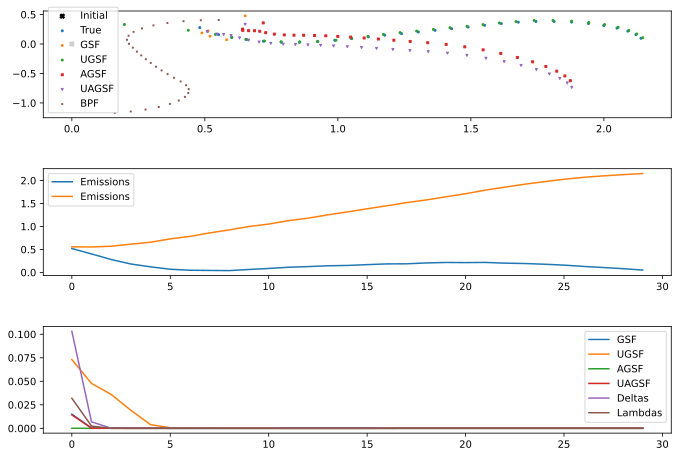

sim 85/100
key0:  [3527989559  201165388]
key:  [3319928876 2413533594]
       Time taken for GSF:  0.9912381172180176
       Time taken for UGSF:  1.060765027999878
       Time taken for AGSF:  5.223327159881592
       Time taken for UAGSF:  5.529567003250122
       Time taken for BPF:  0.5745091438293457
              GSF RMSE: 0.024456754
              UGSF RMSE: 0.041280404
              AGSF RMSE: 0.18509872
              UAGSF RMSE: 1.8772111
              BPF RMSE: 0.81797904


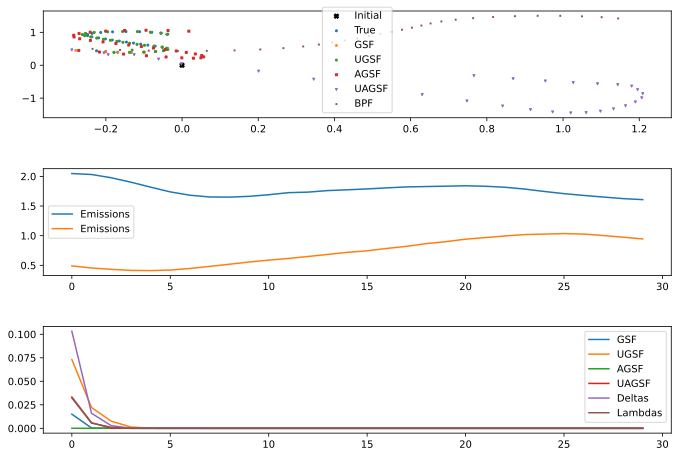

sim 86/100
key0:  [1738606094 3027727165]
key:  [2130493535 3202182244]
       Time taken for GSF:  4.951439142227173
       Time taken for UGSF:  1.10996413230896
       Time taken for AGSF:  5.313992977142334
       Time taken for UAGSF:  5.511104106903076
       Time taken for BPF:  0.5640320777893066
              GSF RMSE: 0.07600574
              UGSF RMSE: 0.09216754
              AGSF RMSE: 1.0137953
              UAGSF RMSE: 0.23813476
              BPF RMSE: 3.1549337


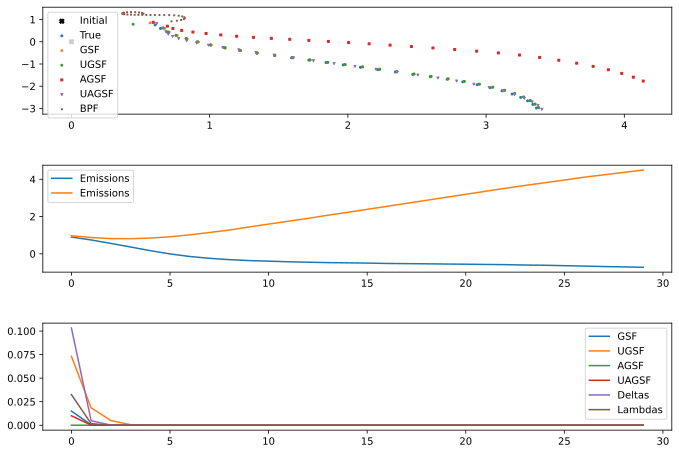

sim 87/100
key0:  [1270597363 4020158462]
key:  [ 975468785 2130504651]
       Time taken for GSF:  0.9778399467468262
       Time taken for UGSF:  1.101168155670166
       Time taken for AGSF:  5.294337749481201
       Time taken for UAGSF:  5.447030067443848
       Time taken for BPF:  0.576897144317627
              GSF RMSE: 0.029305149
              UGSF RMSE: 0.047135677
              AGSF RMSE: 0.4686222
              UAGSF RMSE: 0.52664477
              BPF RMSE: 0.896362


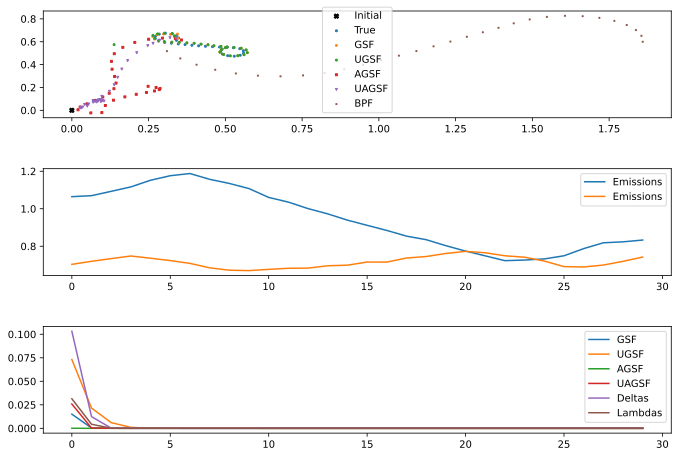

sim 88/100
key0:  [1890969210 1886189240]
key:  [3737732968  541797692]
       Time taken for GSF:  0.9902610778808594
       Time taken for UGSF:  1.0907268524169922
       Time taken for AGSF:  5.3221611976623535
       Time taken for UAGSF:  5.4098060131073
       Time taken for BPF:  0.5699162483215332
              GSF RMSE: 0.07054467
              UGSF RMSE: 0.07406479
              AGSF RMSE: 0.417743
              UAGSF RMSE: 0.09986852
              BPF RMSE: 0.6386648


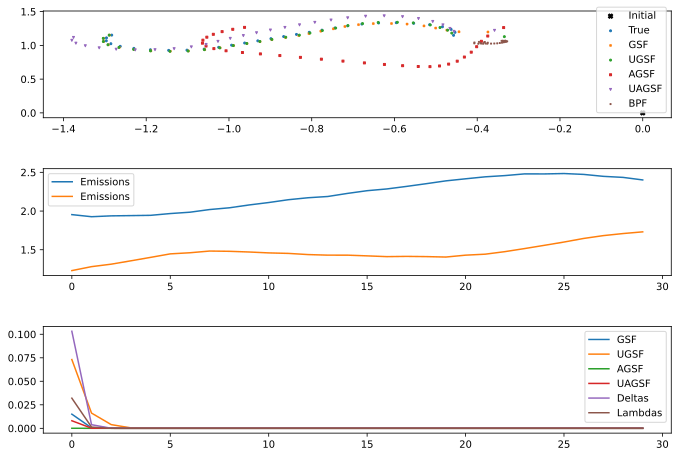

sim 89/100
key0:  [1930838959 3571013835]
key:  [3380473150 1842813300]
       Time taken for GSF:  0.9687058925628662
       Time taken for UGSF:  1.8633320331573486
       Time taken for AGSF:  5.448502063751221
       Time taken for UAGSF:  5.51416015625
       Time taken for BPF:  0.5882728099822998
              GSF RMSE: 0.021912348
              UGSF RMSE: 0.02824701
              AGSF RMSE: 0.8487231
              UAGSF RMSE: 1.0194932
              BPF RMSE: 0.59044164


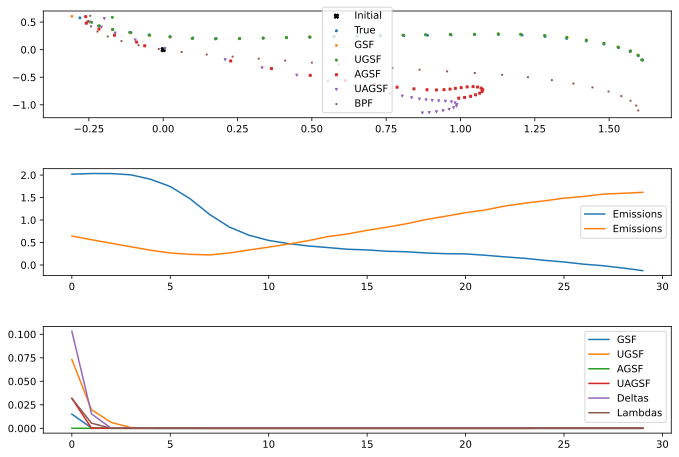

sim 90/100
key0:  [2408631316 4109196784]
key:  [3203281602 1891528791]
       Time taken for GSF:  0.9733703136444092
       Time taken for UGSF:  5.2780210971832275
       Time taken for AGSF:  5.421232223510742
       Time taken for UAGSF:  5.502840757369995
       Time taken for BPF:  0.5873751640319824
              GSF RMSE: 0.025214523
              UGSF RMSE: 0.029906629
              AGSF RMSE: 0.40721545
              UAGSF RMSE: 0.4521485
              BPF RMSE: 0.28070512


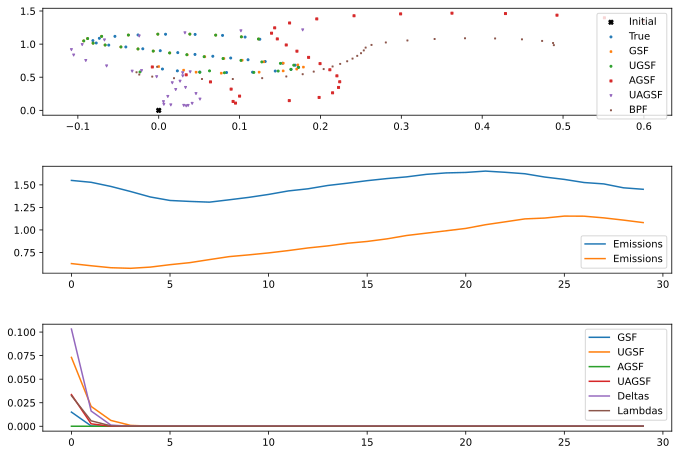

sim 91/100
key0:  [4109227876  335414910]
key:  [4160417025  928684538]
       Time taken for GSF:  0.9443562030792236
       Time taken for UGSF:  1.1515350341796875
       Time taken for AGSF:  5.307261943817139
       Time taken for UAGSF:  5.421525001525879
       Time taken for BPF:  0.579754114151001
              GSF RMSE: 0.043823484
              UGSF RMSE: 0.04689639
              AGSF RMSE: 0.849398
              UAGSF RMSE: 1.1422911
              BPF RMSE: 2.0534012


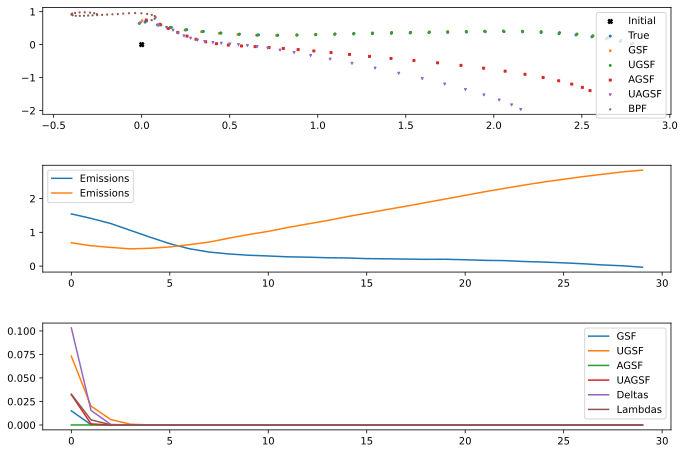

sim 92/100
key0:  [3624893526 2777656520]
key:  [3249949232 2315826805]
       Time taken for GSF:  0.9776277542114258
       Time taken for UGSF:  1.1397919654846191
       Time taken for AGSF:  5.600107908248901
       Time taken for UAGSF:  5.491913795471191
       Time taken for BPF:  0.5864920616149902
              GSF RMSE: 0.03761415
              UGSF RMSE: 0.05071505
              AGSF RMSE: 0.9513795
              UAGSF RMSE: 1.1671914
              BPF RMSE: 0.8344449


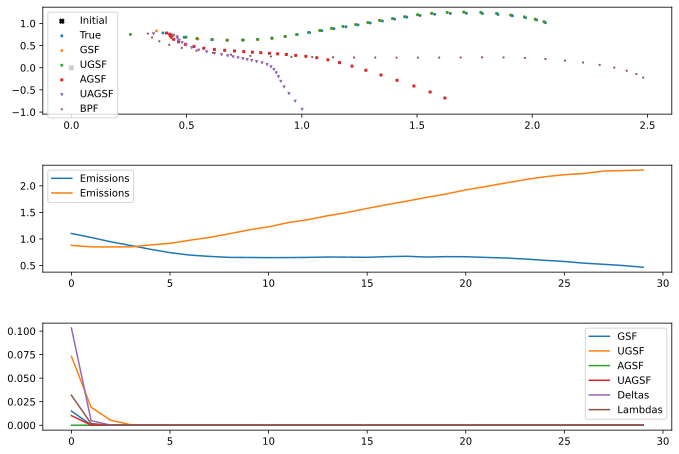

sim 93/100
key0:  [1076503109 3998189389]
key:  [3131066673 1828241873]
       Time taken for GSF:  0.967216968536377
       Time taken for UGSF:  1.0673677921295166
       Time taken for AGSF:  5.231139183044434
       Time taken for UAGSF:  5.421058893203735
       Time taken for BPF:  0.573786735534668
              GSF RMSE: 0.026874505
              UGSF RMSE: 0.040773433
              AGSF RMSE: 0.4747277
              UAGSF RMSE: 0.5205737
              BPF RMSE: 0.8408791


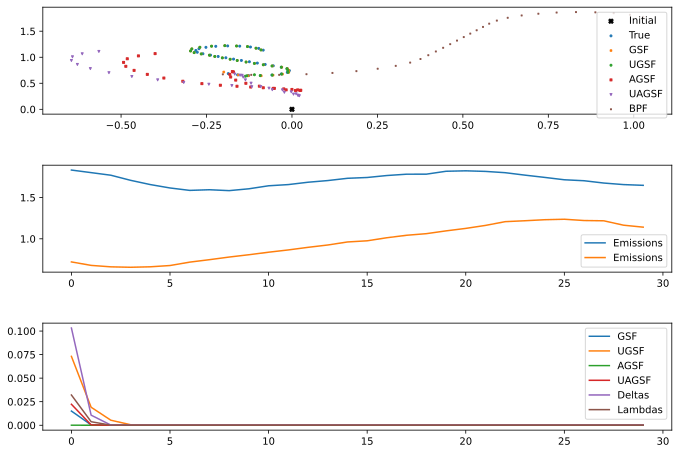

sim 94/100
key0:  [3093408068 1121192653]
key:  [4157461403 2339088927]
       Time taken for GSF:  0.9494249820709229
       Time taken for UGSF:  1.1098730564117432
       Time taken for AGSF:  11.81249713897705
       Time taken for UAGSF:  7.491540908813477
       Time taken for BPF:  0.5940139293670654
              GSF RMSE: 0.045820765
              UGSF RMSE: 0.036087245
              AGSF RMSE: 1.9287916
              UAGSF RMSE: 1.2223306
              BPF RMSE: 0.33913812


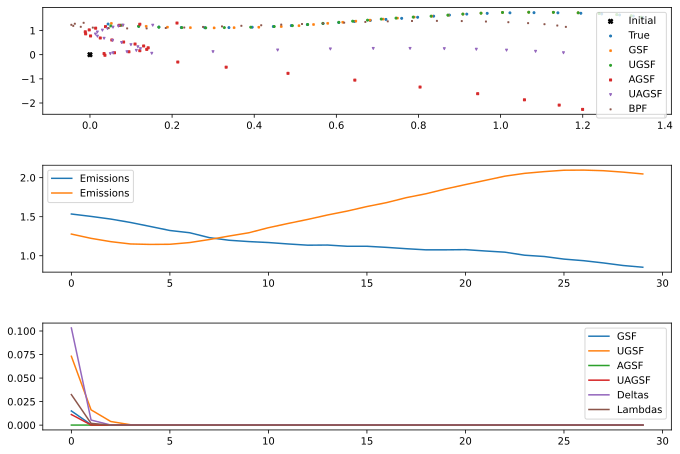

sim 95/100
key0:  [2368165947 3767300836]
key:  [494107837 847257214]
       Time taken for GSF:  0.9996299743652344
       Time taken for UGSF:  1.0674710273742676
       Time taken for AGSF:  5.22141695022583
       Time taken for UAGSF:  5.591380834579468
       Time taken for BPF:  0.580690860748291
              GSF RMSE: 0.050658196
              UGSF RMSE: 0.04979183
              AGSF RMSE: 0.4447991
              UAGSF RMSE: 0.7064388
              BPF RMSE: 1.245899


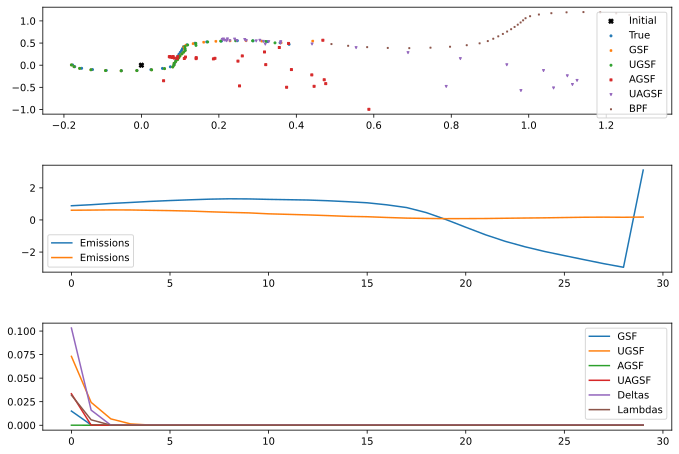

sim 96/100
key0:  [1724406739 1751605629]
key:  [3386218830 3594907482]
       Time taken for GSF:  0.9245853424072266
       Time taken for UGSF:  1.0350983142852783
       Time taken for AGSF:  5.245097875595093
       Time taken for UAGSF:  5.640902042388916
       Time taken for BPF:  0.5778768062591553
              GSF RMSE: 0.025147256
              UGSF RMSE: 0.06102651
              AGSF RMSE: 0.9117277
              UAGSF RMSE: 0.54260725
              BPF RMSE: 1.549086


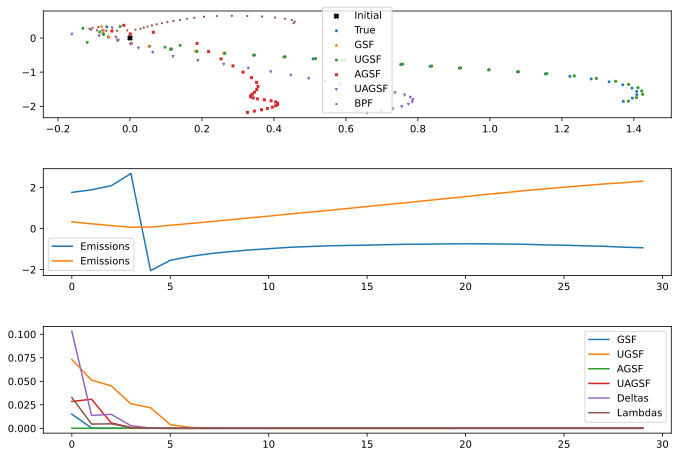

sim 97/100
key0:  [209844117 932810560]
key:  [4069255975 3434966514]
       Time taken for GSF:  0.9510970115661621
       Time taken for UGSF:  1.0571749210357666
       Time taken for AGSF:  6.295868158340454
       Time taken for UAGSF:  5.582902193069458
       Time taken for BPF:  0.5976800918579102
              GSF RMSE: 0.051366765
              UGSF RMSE: 0.047407687
              AGSF RMSE: 1.1113027
              UAGSF RMSE: 2.751538
              BPF RMSE: 0.72899956


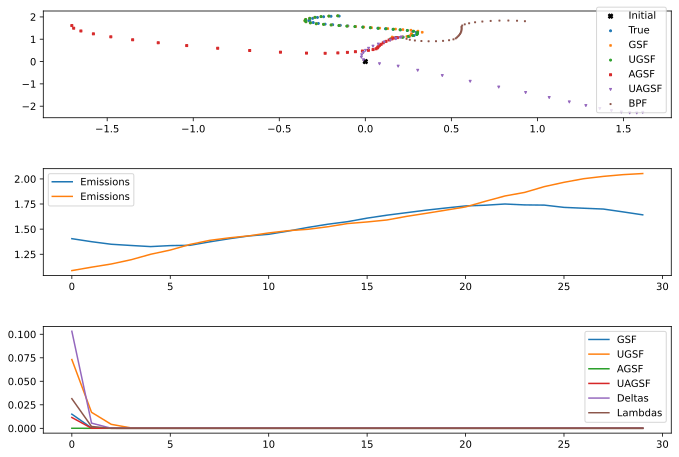

sim 98/100
key0:  [1971833268 3810184210]
key:  [ 842754151 3463081024]
       Time taken for GSF:  0.941669225692749
       Time taken for UGSF:  1.068371295928955
       Time taken for AGSF:  5.187707185745239
       Time taken for UAGSF:  10.016726016998291
       Time taken for BPF:  0.5982329845428467
              GSF RMSE: 0.04306961
              UGSF RMSE: 0.042657886
              AGSF RMSE: 1.4114264
              UAGSF RMSE: 1.4940418
              BPF RMSE: 0.3315994


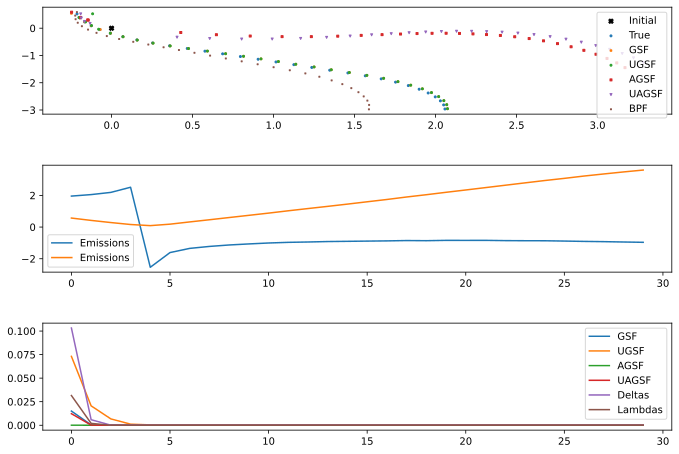

sim 99/100
key0:  [1951263449 2520687282]
key:  [1824873217 1349310974]
       Time taken for GSF:  0.9665160179138184
       Time taken for UGSF:  1.071251392364502
       Time taken for AGSF:  5.2014000415802
       Time taken for UAGSF:  5.401201009750366
       Time taken for BPF:  0.5691437721252441
              GSF RMSE: 0.08517261
              UGSF RMSE: 0.051073544
              AGSF RMSE: 0.2738457
              UAGSF RMSE: 0.33068848
              BPF RMSE: 0.97278094


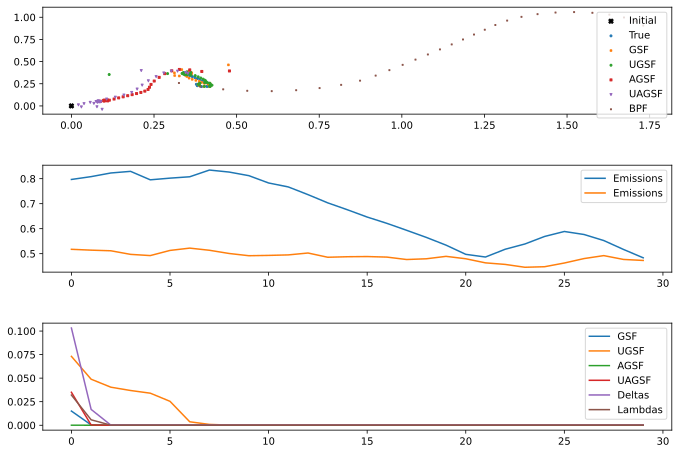

sim 100/100
key0:  [2815106496 4119242553]
key:  [3871773583 2752233313]
       Time taken for GSF:  0.9399538040161133
       Time taken for UGSF:  1.1139659881591797
       Time taken for AGSF:  5.17048978805542
       Time taken for UAGSF:  5.484225749969482
       Time taken for BPF:  0.5737090110778809
              GSF RMSE: 0.042923138
              UGSF RMSE: 0.06236116
              AGSF RMSE: 0.3632663
              UAGSF RMSE: 0.2393339
              BPF RMSE: 0.50705314


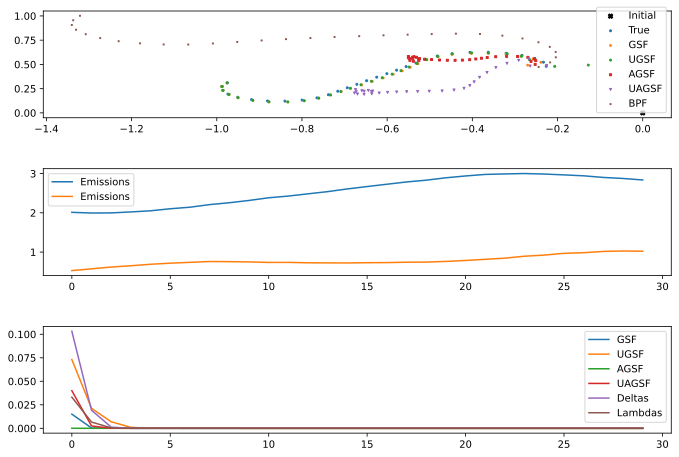

In [5]:
verbose = False
Nsim = 100
gsf_rmse = jnp.zeros(Nsim)
ugsf_rmse = jnp.zeros(Nsim)
agsf_rmse = jnp.zeros(Nsim)
uagsf_rmse = jnp.zeros(Nsim)
bpf_rmse = jnp.zeros(Nsim)

gsf_norm = jnp.zeros((Nsim, seq_length))
ugsf_norm = jnp.zeros((Nsim, seq_length))
agsf_norm = jnp.zeros((Nsim, seq_length))
uagsf_norm = jnp.zeros((Nsim, seq_length))
bpf_norm = jnp.zeros((Nsim, seq_length))

gsf_time = jnp.zeros(Nsim)
ugsf_time = jnp.zeros(Nsim)
agsf_time = jnp.zeros(Nsim)
uagsf_time = jnp.zeros(Nsim)
bpf_time = jnp.zeros(Nsim)
next_key = jr.PRNGKey(1)
for i in range(Nsim):
    print('sim {}/{}'.format(i+1, Nsim))
    # Generate Data
    key0, key, next_key = jr.split(next_key, 3)
    print('key0: ', key0)
    print('key: ', key)
    states, emissions = model.sample(params, key0, seq_length, inputs = inputs)

    # GSF
    M = 3
    tin = time.time()
    posterior_filtered_gsf = gf.gaussian_sum_filter(params, emissions, M, 1, inputs)
    point_estimate_gsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_gsf.means, posterior_filtered_gsf.weights), axis=0)
    tout = time.time()
    t_gsf= tout - tin
    print('       Time taken for GSF: ', tout - tin)

    # U-GSF
    tin = time.time()
    uparams = ParamsUKF(1,0,0)
    posterior_filtered_ugsf = gf.unscented_gaussian_sum_filter(params, uparams, emissions, M, 1, inputs)
    point_estimate_ugsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_ugsf.means, posterior_filtered_ugsf.weights), axis=0)
    tout = time.time()
    t_ugsf= tout - tin
    print('       Time taken for UGSF: ', tout - tin)

    # AGSF
    opt_args = (0.5, 0.5)
    num_components = [M, 2, 2] # has to be set correctly OW "TypeError: Cannot interpret '<function <lambda> at 0x12eae3ee0>' as a data type". Check internal containers._branch_from_node

    tin = time.time()
    posterior_filtered_agsf, aux_outputs = gf.augmented_gaussian_sum_filter(params, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)    
    point_estimate_agsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_agsf.means, posterior_filtered_agsf.weights), axis=0)
    tout = time.time()
    t_agsf= tout - tin
    print('       Time taken for AGSF: ', tout - tin)

    # U-AGSF
    tin = time.time()
    posterior_filtered_uagsf, aux_outputs = gf.unscented_agsf(params, uparams, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)
    point_estimate_uagsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_uagsf.means, posterior_filtered_uagsf.weights), axis=0)
    tout = time.time()
    t_uagsf= tout - tin
    print('       Time taken for UAGSF: ', tout - tin)



    # AGSF Optimal
    # tin = time.time()
    # posterior_filtered_agsf_opt, aux_outputs_opt = gf.augmented_gaussian_sum_filter_optimal(params, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)    
    # point_estimate_agsf_opt = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_agsf_opt.means, posterior_filtered_agsf_opt.weights), axis=0)
    # tout = time.time()
    # t_agsf_opt= tout - tin
    # print('       Time taken for AGSF optimal: ', tout - tin)

    # BPF
    tin = time.time()
    num_particles = 100

    params_bpf = ParamsBPF(
        initial_mean=mu0,
        initial_covariance=Sigma0,
        dynamics_function=f,
        dynamics_noise_bias=q0,
        dynamics_noise_covariance=Q,
        emission_function=g,
        emission_noise_bias=r0,
        emission_noise_covariance=R,
        emission_distribution_log_prob = glp
    )

    posterior_bpf = gf.bootstrap_particle_filter(params_bpf, emissions, num_particles, key, inputs)
    point_estimate_bpf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_bpf["particles"], posterior_bpf["weights"]), axis=0)
    tout = time.time()
    t_bpf = tout - tin
    print('       Time taken for BPF: ', tout - tin)

    # Computation of errors
    gsf_rmse = gsf_rmse.at[i].set(utils.rmse(point_estimate_gsf, states))
    ugsf_rmse = ugsf_rmse.at[i].set(utils.rmse(point_estimate_ugsf, states))
    agsf_rmse = agsf_rmse.at[i].set(utils.rmse(point_estimate_agsf, states))
    uagsf_rmse = uagsf_rmse.at[i].set(utils.rmse(point_estimate_uagsf, states))
    bpf_rmse = bpf_rmse.at[i].set(utils.rmse(point_estimate_bpf, states))

    print('              GSF RMSE:', gsf_rmse[i])                                                                           
    print('              UGSF RMSE:', ugsf_rmse[i])
    print('              AGSF RMSE:', agsf_rmse[i])
    print('              UAGSF RMSE:', uagsf_rmse[i])
    print('              BPF RMSE:', bpf_rmse[i])

    gsf_norm = gsf_norm.at[i].set(jnp.linalg.norm(point_estimate_gsf - states, axis = 1))
    ugsf_norm = ugsf_norm.at[i].set(jnp.linalg.norm(point_estimate_ugsf - states, axis = 1))
    agsf_norm = agsf_norm.at[i].set(jnp.linalg.norm(point_estimate_agsf - states, axis = 1))
    uagsf_norm = uagsf_norm.at[i].set(jnp.linalg.norm(point_estimate_uagsf - states, axis = 1))
    bpf_norm = bpf_norm.at[i].set(jnp.linalg.norm(point_estimate_bpf - states, axis = 1))

    gsf_time = gsf_time.at[i].set(t_gsf)
    ugsf_time = ugsf_time.at[i].set(t_ugsf)
    agsf_time = agsf_time.at[i].set(t_agsf)
    uagsf_time = uagsf_time.at[i].set(t_uagsf)
    bpf_time = bpf_time.at[i].set(t_bpf)

    fig, axes = plt.subplots(3, 1, sharex=False, figsize=(10, 7))
    fig.tight_layout(pad=3.0)
    axes[0].scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
    axes[0].scatter(states[:,0], states[:,2], label = 'True', s = 4)
    axes[0].scatter(point_estimate_gsf[:,0], point_estimate_gsf[:,2], label = 'GSF', s = 4, marker = 'x')
    axes[0].scatter(point_estimate_ugsf[:,0], point_estimate_ugsf[:,2], label = 'UGSF', s = 4, marker = 'o')
    axes[0].scatter(point_estimate_agsf[:,0], point_estimate_agsf[:,2], label = 'AGSF', s = 4, marker = 's')
    axes[0].scatter(point_estimate_uagsf[:,0], point_estimate_uagsf[:,2], label = 'UAGSF', s = 4, marker = 'v')
    axes[0].scatter(point_estimate_bpf[:,0], point_estimate_bpf[:,2], label = 'BPF', s = 4, marker = '+')
    axes[0].legend()   

    axes[1].plot(emissions, label = 'Emissions')
    axes[1].legend()

    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_gsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'GSF')
    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_ugsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'UGSF')
    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_agsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'AGSF')
    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_uagsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'UAGSF')
    axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Deltas'], axis1=2, axis2=3), axis=1)/5, label = 'Deltas')
    axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Lambdas'], axis1=2, axis2=3), axis=1)/25, label = 'Lambdas')
    axes[2].legend()

 

    plt.show()

In [6]:
ind = jnp.argwhere(jnp.isnan(gsf_rmse)).flatten()
gsf_rmse = jnp.delete(gsf_rmse, ind, axis = 0)

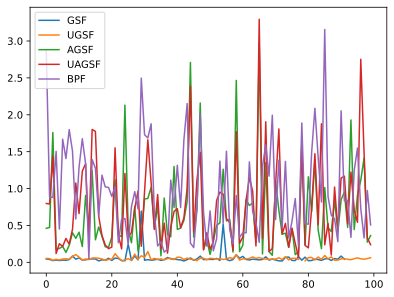

In [7]:
plt.plot(gsf_rmse, label = 'GSF')
plt.plot(ugsf_rmse, label = 'UGSF')
plt.plot(agsf_rmse, label = 'AGSF')
plt.plot(uagsf_rmse, label = 'UAGSF')
plt.plot(bpf_rmse, label = 'BPF')
plt.legend()
plt.show()

In [8]:
import pandas as pd
def bootstrap(key, rmse_array, B):
    N = rmse_array.shape[0]
    rmse_boot = jnp.zeros((B,))
    for b in range(B):
        key, subkey = jr.split(key)
        ind = jr.randint(subkey, (N,), 0, N)
        rmse_boot = rmse_boot.at[b].set(jnp.mean(rmse_array[ind]))
    return rmse_boot

keys = jr.split(jr.PRNGKey(0), 5)
B = 100
gsf_boot = bootstrap(keys[0], gsf_rmse, B)
ugsf_boot = bootstrap(keys[1], ugsf_rmse, B)
agsf_boot = bootstrap(keys[2], agsf_rmse, B)
uagsf_boot = bootstrap(keys[3], uagsf_rmse, B)
bpf_boot = bootstrap(keys[4], bpf_rmse, B)


gsf_armse = jnp.mean(gsf_boot)
ugsf_armse = jnp.mean(ugsf_boot)
agsf_armse = jnp.mean(agsf_boot)
uagsf_armse = jnp.mean(uagsf_boot)
bpf_armse = jnp.mean(bpf_boot)

# gsf_armse = jnp.mean(gsf_rmse)
# ugsf_armse = jnp.mean(ugsf_rmse)
# agsf_armse = jnp.mean(agsf_rmse)
# uagsf_armse = jnp.mean(uagsf_rmse)
# bpf_armse = jnp.mean(bpf_rmse)

gsf_atime = jnp.mean(gsf_time)
ugsf_atime = jnp.mean(ugsf_time)
agsf_atime = jnp.mean(agsf_time)
uagsf_atime = jnp.mean(uagsf_time)
bpf_atime = jnp.mean(bpf_time)

gsf_tab_out = '{:10.2f}±{:10.2f}'.format(gsf_armse, jnp.std(gsf_boot))
ugsf_tab_out = '{:10.2f}±{:10.2f}'.format(ugsf_armse, jnp.std(ugsf_boot))
agsf_tab_out = '{:10.2f}±{:10.2f}'.format(agsf_armse, jnp.std(agsf_boot))
uagsf_tab_out = '{:10.2f}±{:10.2f}'.format(uagsf_armse, jnp.std(uagsf_boot))
bpf_tab_out = '{:10.2f}±{:10.2f}'.format(bpf_armse, jnp.std(bpf_boot))

gsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(gsf_atime, jnp.std(gsf_time))
ugsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(ugsf_atime, jnp.std(ugsf_time))
agsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(agsf_atime, jnp.std(agsf_time))
uagsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(uagsf_atime, jnp.std(uagsf_time))
bpf_tab_out1 = '{:10.2f}±{:10.2f}'.format(bpf_atime, jnp.std(bpf_time))

df = pd.DataFrame(columns = [' ','RMSE','time(s)'])
# df[' '] = ['GSF', 'AGSF', 'AGSF Optimal', 'BPF']
# df['RMSE'] = [gsf_tab_out, agsf_tab_out, agsf_opt_tab_out, bpf_tab_out]
# df['time(s)'] = [gsf_tab_out1, agsf_tab_out1, agsf_opt_tab_out1, bpf_tab_out1]
df[' '] = ['GSF','UGSF', 'AGSF', 'UAGSF', 'BPF']
df['RMSE'] = [gsf_tab_out, ugsf_tab_out, agsf_tab_out, uagsf_tab_out, bpf_tab_out]
df['time(s)'] = [gsf_tab_out1, ugsf_tab_out1, agsf_tab_out1, uagsf_tab_out1, bpf_tab_out1]
print(df.to_latex(index=False))
df

\begin{tabular}{lll}
\toprule
  & RMSE & time(s) \\
\midrule
GSF &       0.05±      0.01 &       1.02±      0.47 \\
UGSF &        nan±       nan &       1.14±      0.58 \\
AGSF &       0.67±      0.06 &       5.49±      1.03 \\
UAGSF &       0.76±      0.07 &       6.52±     10.11 \\
BPF &       0.97±      0.07 &       0.62±      0.39 \\
\bottomrule
\end{tabular}



RMSE                time(s)
0    GSF        0.05±      0.01        1.02±      0.47
1   UGSF         nan±       nan        1.14±      0.58
2   AGSF        0.67±      0.06        5.49±      1.03
3  UAGSF        0.76±      0.07        6.52±     10.11
4    BPF        0.97±      0.07        0.62±      0.39